# Import Libraries

In [4]:
import pandas as pd
import os
import pyomo.environ as pyo 
import numpy  as np
import matplotlib.pyplot as plt
from datetime import datetime
import gurobipy as gp
from gurobipy import GRB
Data_path_GDrive = "G:/Il mio Drive/Thesis_Large_Files/Working Table"
Data_path_Production = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Production"
Data_path_Consumption = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Consumption"
Data_path_Users = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Users"
results_dir = 'C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results'
results_dir = os.path.join(results_dir, datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(results_dir, exist_ok=True)
plot_dir = os.path.join(results_dir,'Plot')
yearly_plot_dir = os.path.join(plot_dir,'Yearly_Plot')
weekly_plot_dir = os.path.join(plot_dir,'Weekly_Plot')
Data_path_GDrive = "G:/Il mio Drive/Thesis_Large_Files/Working Table"


# Processing Tables

In [ ]:
# Load DataFrames
DF_name = "2019_ProductionEast.csv"
DF_path = os.path.join(Data_path_Production, DF_name)
DF_East = pd.read_csv(DF_path, sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])

DF_name = "2019_ProductionSouth.csv"
DF_path = os.path.join(Data_path_Production, DF_name)
DF_South = pd.read_csv(DF_path, sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])

DF_name = "2019_ProductionWest.csv"
DF_path = os.path.join(Data_path_Production, DF_name)
DF_West = pd.read_csv(DF_path, sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])

DF_name = "2019_ConsumptionCurve.csv"
DF_path = os.path.join(Data_path_Consumption, DF_name)
DF_Consumption = pd.read_csv(DF_path, sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])

DF_name = "Thesis_User_Residential.csv"
DF_path = os.path.join(Data_path_Users, DF_name)
DF_m2_Residential = pd.read_csv(DF_path,sep=",",on_bad_lines='skip', header=0, parse_dates=[0])

DF_name = "Thesis_User_Industrial.csv"
DF_path = os.path.join(Data_path_Users, DF_name)
DF_m2_Industrial = pd.read_csv(DF_path,sep=",",on_bad_lines='skip', header=0, parse_dates=[0])

DF_name = "Thesis_User_Commercial.csv"
DF_path = os.path.join(Data_path_Users, DF_name)
DF_m2_Commercial = pd.read_csv(DF_path,sep=",",on_bad_lines='skip', header=0, parse_dates=[0])

# List of your dataframes
dataframes = [DF_South, DF_East, DF_West]

# Function to change the datetime index format
def change_datetime_index_format(df):
    df.index = df.index.astype(str)
    df.index = pd.to_datetime(df.index, format='%Y%m%d:%H%M')
    df.index = df.index.strftime('%Y%m%d %H:%M')
    df.index = pd.to_datetime(df.index, format='%Y%m%d %H:%M')
    return df

# Apply the function to each dataframe
dataframes = [change_datetime_index_format(df) for df in dataframes]

# Unpack the dataframes back to their original names if needed
DF_South, DF_East, DF_West = dataframes

# Extract the G(i) column from each DataFrame and rename it
DF_South_Gi = DF_South[['G(i)']].rename(columns={'G(i)': 'G(i)_South'})
DF_East_Gi = DF_East[['G(i)']].rename(columns={'G(i)': 'G(i)_East'})
DF_West_Gi = DF_West[['G(i)']].rename(columns={'G(i)': 'G(i)_West'})

# Combine the columns into a new DataFrame
DF_Production = pd.concat([DF_South_Gi, DF_East_Gi, DF_West_Gi], axis=1)

# Define paths to save the files
DF_Production_name_csv = "2019_Production.csv"
DF_Production_name_xlsx = "2019_Production.xlsx"
DF_path_csv = os.path.join(Data_path_Production, DF_Production_name_csv)
DF_path_xlsx = os.path.join(Data_path_Production, DF_Production_name_xlsx)

# Save the new DataFrame to CSV and Excel
DF_Production.to_csv(DF_path_csv, index=True)
DF_Production.to_excel(DF_path_xlsx, index=True)

# Save the updated DF_Consumption back to CSV with the modified index
DF_Consumption_name_csv = "2019_ConsumptionCurve.csv"
DF_path_consumption_csv = os.path.join(Data_path_Consumption, DF_Consumption_name_csv)
DF_Consumption.to_csv(DF_path_consumption_csv, index=True)

In [ ]:
# Data from paper for available roof production Area
DoublePitched = 0.5 * 0.6 * 0.85 * 0.7 * 0.5
Industrial = 0.8 * 0.9 * 1 * 0.45 * 1 * 0.45 * 1
Flat = 1 * 0.6 * 0.9 * 0.45 * 0.5
costheta_Res = np.cos(20 * np.pi / 180)
costheta_Ind = np.cos(30 * np.pi / 180)
costheta_Com = np.cos(0 * np.pi / 180)
CoefRes = (DoublePitched * 0.95 + Flat * 0.05) / costheta_Res
CoefInd = Industrial / costheta_Ind
CoefCom = (Flat * 0.5 + DoublePitched * 0.5) / costheta_Com
Limit = 2
nPVLimit = 1.63 * Limit

#Change Area from string to float
DF_m2_Residential['Area'] = DF_m2_Residential['Area'].astype(str)
DF_m2_Industrial['Area'] = DF_m2_Industrial['Area'].astype(str)
DF_m2_Commercial['Area'] = DF_m2_Commercial['Area'].astype(str)

DF_m2_Residential['Area'] = DF_m2_Residential['Area'].str.replace(',', '.')
DF_m2_Industrial['Area'] = DF_m2_Industrial['Area'].str.replace(',', '.')
DF_m2_Commercial['Area'] = DF_m2_Commercial['Area'].str.replace(',', '.')

DF_m2_Residential['Area'] = DF_m2_Residential['Area'].astype(float)
DF_m2_Industrial['Area'] = DF_m2_Industrial['Area'].astype(float)
DF_m2_Commercial['Area'] = DF_m2_Commercial['Area'].astype(float)
DF_m2_Residential['Area'] = DF_m2_Residential['Area'] * CoefRes
DF_m2_Industrial['Area'] = DF_m2_Industrial['Area'] * CoefInd
DF_m2_Commercial['Area'] = DF_m2_Commercial['Area'] * CoefCom

# Delete rows where 'Area' column values are less than nPVLimit
DF_m2_Residential = DF_m2_Residential[DF_m2_Residential['Area'] >= nPVLimit]
DF_m2_Industrial = DF_m2_Industrial[DF_m2_Industrial['Area'] >= nPVLimit]
DF_m2_Commercial = DF_m2_Commercial[DF_m2_Commercial['Area'] >= nPVLimit]

# Reset the index
DF_m2_Residential = DF_m2_Residential.reset_index(drop=True)
DF_m2_Industrial = DF_m2_Industrial.reset_index(drop=True)
DF_m2_Commercial = DF_m2_Commercial.reset_index(drop=True)

In [ ]:
# Function to generate random alpha values with two decimal places
def generate_alpha_columns(df):
    def round_and_adjust(row):
        row = np.round(row, 2)
        row_diff = 1.0 - row.sum()
        for i in range(len(row)):
            if row_diff == 0:
                break
            adjustment = np.round(min(row_diff, 0.01 if row_diff > 0 else -0.01), 2)
            if (row[i] + adjustment >= 0) and (row[i] + adjustment <= 1):
                row[i] += adjustment
                row_diff -= adjustment
        return row

    # Generate random values
    random_values = np.random.rand(len(df), 3)
    # Normalize the values to ensure they sum to 1
    random_values /= random_values.sum(axis=1)[:, None]
    # Round values to two decimal places and adjust to ensure they sum to 1
    adjusted_values = np.apply_along_axis(round_and_adjust, 1, random_values)
    # Create new columns
    df['S_coeff'] = adjusted_values[:, 0]
    df['W_coeff'] = adjusted_values[:, 1]
    df['E_coeff'] = adjusted_values[:, 2]
    return df

# Assuming DF_m2_Residential, DF_m2_Industrial, DF_m2_Commercial are already defined
dataframes = [DF_m2_Residential, DF_m2_Industrial, DF_m2_Commercial]

# Apply the function to each dataframe
dataframes = [generate_alpha_columns(df) for df in dataframes]

# Unpack the dataframes back to their original names if needed
DF_m2_Residential, DF_m2_Industrial, DF_m2_Commercial = dataframes

#Save
DF_m2_Residential.to_csv(os.path.join(results_dir, 'DF_m2_Residential.csv'), index=False)
DF_m2_Industrial.to_csv(os.path.join(results_dir, 'DF_m2_Industrial.csv'), index=False)
DF_m2_Commercial.to_csv(os.path.join(results_dir, 'DF_m2_Commercial.csv'), index=False)

# Calculate the production for each residential user
Residential_user_production = (DF_Production['G(i)_South'].values[:, None] * DF_m2_Residential['S_coeff'].values +
                               DF_Production['G(i)_East'].values[:, None] * DF_m2_Residential['E_coeff'].values +
                               DF_Production['G(i)_West'].values[:, None] * DF_m2_Residential['W_coeff'].values)

# Create a DataFrame for residential user production
Residential_user_production_df = pd.DataFrame(Residential_user_production, index=DF_Production.index, columns=DF_m2_Residential.index)

# Calculate the production for each industrial user
Industrial_user_production = (DF_Production['G(i)_South'].values[:, None] * DF_m2_Industrial['S_coeff'].values +
                              DF_Production['G(i)_East'].values[:, None] * DF_m2_Industrial['E_coeff'].values +
                              DF_Production['G(i)_West'].values[:, None] * DF_m2_Industrial['W_coeff'].values)

# Create a DataFrame for industrial user production
Industrial_user_production_df = pd.DataFrame(Industrial_user_production, index=DF_Production.index, columns=DF_m2_Industrial.index)

# Calculate the production for each commercial user
Commercial_user_production = (DF_Production['G(i)_South'].values[:, None] * DF_m2_Commercial['S_coeff'].values +
                              DF_Production['G(i)_East'].values[:, None] * DF_m2_Commercial['E_coeff'].values +
                              DF_Production['G(i)_West'].values[:, None] * DF_m2_Commercial['W_coeff'].values)

# Create a DataFrame for commercial user production
Commercial_user_production_df = pd.DataFrame(Commercial_user_production, index=DF_Production.index, columns=DF_m2_Commercial.index)

# Save the user production DataFrames to CSV files
Residential_user_production_df.to_csv(os.path.join(results_dir, 'Residential_user_production.csv'))
Industrial_user_production_df.to_csv(os.path.join(results_dir, 'Industrial_user_production.csv'))
Commercial_user_production_df.to_csv(os.path.join(results_dir, 'Commercial_user_production.csv'))

# Check the result (optional)
print(Residential_user_production_df.head())
print(Industrial_user_production_df.head())
print(Commercial_user_production_df.head())


# Optimization with Gurobi

In [2]:
import pandas as pd
import os
import pyomo.environ as pyo 
import numpy  as np
import matplotlib.pyplot as plt
from datetime import datetime
import gurobipy as gp
from gurobipy import GRB


Data_path_Production = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Production"
Data_path_Consumption = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Consumption"
Data_path_Users = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Users"
results_dir = 'C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results'
results_dir = os.path.join(results_dir, datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(results_dir, exist_ok=True)
plot_dir = os.path.join(results_dir,'Plot')
yearly_plot_dir = os.path.join(plot_dir,'Yearly_Plot')
weekly_plot_dir = os.path.join(plot_dir,'Weekly_Plot')

#Starting Tables for every optimization try
WorkingTables_Path = 'C:/Users/Nik/Documents/GitHub/Thesis/CSV/Working Tables'

DF_m2_Residential = pd.read_csv(os.path.join(WorkingTables_Path, 'DF_m2_Residential.csv'), sep=",", on_bad_lines='skip', header=0, parse_dates=[0])
DF_m2_Industrial = pd.read_csv(os.path.join(WorkingTables_Path, 'DF_m2_Industrial.csv'), sep=",", on_bad_lines='skip', header=0, parse_dates=[0])
DF_m2_Commercial = pd.read_csv(os.path.join(WorkingTables_Path, 'DF_m2_Commercial.csv'), sep=",", on_bad_lines='skip', header=0, parse_dates=[0])

Residential_user_production_df = pd.read_csv(os.path.join(Data_path_GDrive, 'Residential_user_production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])Industrial_user_production_df = pd.read_csv(os.path.join(WorkingTables_Path, 'Industrial_user_production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
Commercial_user_production_df = pd.read_csv(os.path.join(WorkingTables_Path, 'Commercial_user_production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
DF_Consumption = pd.read_csv(os.path.join(Data_path_Consumption, '2019_ConsumptionCurve.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
DF_Production = pd.read_csv(os.path.join(Data_path_Production, '2019_Production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])

# Convert the indices of the user DataFrames to strings
DF_m2_Residential.index = DF_m2_Residential.index.astype(str)
DF_m2_Industrial.index = DF_m2_Industrial.index.astype(str)
DF_m2_Commercial.index = DF_m2_Commercial.index.astype(str)

# Convert the columns of the production DataFrames to strings
Residential_user_production_df.columns = Residential_user_production_df.columns.astype(str)
Industrial_user_production_df.columns = Industrial_user_production_df.columns.astype(str)
Commercial_user_production_df.columns = Commercial_user_production_df.columns.astype(str)

# Set the maximum area constraint
Area_Res_Max = 1000000
Area_Ind_Max = 20000
Area_Com_Max = 50000

# Define the yearlist based on the number of hours
yearlist = DF_Production.index

# Create a new Gurobi model
m = gp.Model("Optimization_Model_BinaryonProduction")

# Production Binary Variables [0;1]
binary_vars_production_residential = m.addVars(DF_m2_Residential.index, vtype=GRB.BINARY, name="binary_production_residential")
binary_vars_production_industrial = m.addVars(DF_m2_Industrial.index, vtype=GRB.BINARY, name="binary_production_industrial")
binary_vars_production_commercial = m.addVars(DF_m2_Commercial.index, vtype=GRB.BINARY, name="binary_production_commercial")

# Auxiliary variable for absolute deviation
deviation = m.addVars(yearlist, lb=0, vtype=GRB.CONTINUOUS, name="deviation")

# Set initial values to 1 for binary variables
for var in binary_vars_production_residential.values():
    var.start = 1
for var in binary_vars_production_industrial.values():
    var.start = 1
for var in binary_vars_production_commercial.values():
    var.start = 1

# Calculate the difference between production and consumption for each hour
difference = {
    t: (gp.quicksum(binary_vars_production_residential[user] * Residential_user_production_df.loc[t, user] for user in DF_m2_Residential.index) -
        (DF_Consumption.loc[t, 'Residential'] * Area_Res_Max) +
        gp.quicksum(binary_vars_production_industrial[user] * Industrial_user_production_df.loc[t, user] for user in DF_m2_Industrial.index) -
        (DF_Consumption.loc[t, 'Industrial'] * Area_Ind_Max) +
        gp.quicksum(binary_vars_production_commercial[user] * Commercial_user_production_df.loc[t, user] for user in DF_m2_Commercial.index) -
        (DF_Consumption.loc[t, 'Commercial'] * Area_Com_Max))
    for t in yearlist
}


# Add constraint to define the absolute value of the deviation
for t in yearlist:
    m.addConstr(deviation[t] >= difference[t], name=f"PosDeviation_{t}")
    m.addConstr(deviation[t] >= -difference[t], name=f"NegDeviation_{t}")

# Objective function: minimize the deviation
m.setObjective(gp.quicksum(deviation[t] for t in yearlist), GRB.MINIMIZE)

# Set solver parameters
m.Params.MIPGap = 0.005

# Optimize the model
m.optimize()

# Display the results
for v in m.getVars():
    print(f'{v.varName}: {v.x}')

print(f'Objective: {m.objVal}')

# Extract results
RP_values = {i: binary_vars_production_residential[i].X for i in DF_m2_Residential.index}
IP_values = {i: binary_vars_production_industrial[i].X for i in DF_m2_Industrial.index}
CP_values = {i: binary_vars_production_commercial[i].X for i in DF_m2_Commercial.index}

# Create new DataFrames with the chosen binary variables
DF_m2_Residential['Chosen'] = [RP_values[user] for user in DF_m2_Residential.index]
DF_m2_Industrial['Chosen'] = [IP_values[user] for user in DF_m2_Industrial.index]
DF_m2_Commercial['Chosen'] = [CP_values[user] for user in DF_m2_Commercial.index]

chosen_residential = DF_m2_Residential[DF_m2_Residential['Chosen'] == 1]
chosen_industrial = DF_m2_Industrial[DF_m2_Industrial['Chosen'] == 1]
chosen_commercial = DF_m2_Commercial[DF_m2_Commercial['Chosen'] == 1]

# Save the results to CSV files
chosen_residential.to_csv(os.path.join(results_dir, 'chosen_residential_Test.csv'))
chosen_industrial.to_csv(os.path.join(results_dir, 'chosen_industrial_Test.csv'))
chosen_commercial.to_csv(os.path.join(results_dir, 'chosen_commercial_Test.csv'))

# Calculate the number of chosen users versus the total number of users for each category
num_residential_chosen = len(chosen_residential)
num_residential_total = len(DF_m2_Residential)

num_industrial_chosen = len(chosen_industrial)
num_industrial_total = len(DF_m2_Industrial)

num_commercial_chosen = len(chosen_commercial)
num_commercial_total = len(DF_m2_Commercial)

# Print the amounts
print(f'Residential: Chosen = {num_residential_chosen}, Total = {num_residential_total}')
print(f'Industrial: Chosen = {num_industrial_chosen}, Total = {num_industrial_total}')
print(f'Commercial: Chosen = {num_commercial_chosen}, Total = {num_commercial_total}')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-30
Set parameter MIPGap to value 0.005
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 17520 rows, 16922 columns and 69769972 nonzeros
Model fingerprint: 0xd5eb6acf
Variable types: 8760 continuous, 8162 integer (8162 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+06, 6e+06]

Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 9s
Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 12s
Processing user MIP start: 0 nodes explored in subMIP, total elapsed time 16s
User MIP start produced solution with objective 1.69674e+10 (16.14s)
Use

In [3]:

# Calculate total production for residential, industrial, and commercial over time
total_production_residential = [
    sum(RP_values[user] * Residential_user_production_df.loc[t, user] for user in DF_m2_Residential.index)
    for t in yearlist
]

total_production_industrial = [
    sum(IP_values[user] * Industrial_user_production_df.loc[t, user] for user in DF_m2_Industrial.index)
    for t in yearlist
]

total_production_commercial = [
    sum(CP_values[user] * Commercial_user_production_df.loc[t, user] for user in DF_m2_Commercial.index)
    for t in yearlist
]

# Calculate total annual production and consumption difference
total_annual_production_residential = sum(total_production_residential)
total_annual_consumption_residential = DF_Consumption['Residential'].sum() * Area_Res_Max
annual_difference_residential = total_annual_production_residential - total_annual_consumption_residential

total_annual_production_industrial = sum(total_production_industrial)
total_annual_consumption_industrial = DF_Consumption['Industrial'].sum() * Area_Ind_Max
annual_difference_industrial = total_annual_production_industrial - total_annual_consumption_industrial

total_annual_production_commercial = sum(total_production_commercial)
total_annual_consumption_commercial = DF_Consumption['Commercial'].sum() * Area_Com_Max
annual_difference_commercial = total_annual_production_commercial - total_annual_consumption_commercial
total_overall_difference = annual_difference_residential + annual_difference_industrial + annual_difference_commercial

# Calculate percentage of production over consumption for the entire year
percentage_annual_production_residential = (total_annual_production_residential / total_annual_consumption_residential) * 100
percentage_annual_production_industrial = (total_annual_production_industrial / total_annual_consumption_industrial) * 100
percentage_annual_production_commercial = (total_annual_production_commercial / total_annual_consumption_commercial) * 100
percentage_annual_production_overall = ((total_annual_production_residential + total_annual_production_industrial +  total_annual_production_commercial)/ (total_annual_consumption_residential + total_annual_consumption_industrial + total_annual_consumption_commercial)) * 100

# Calculate daily percentage of production over consumption for each day of the year
DF_Consumption['Date'] = DF_Consumption.index.date
daily_consumption = DF_Consumption.groupby('Date').sum()

daily_production_residential = Residential_user_production_df.groupby(Residential_user_production_df.index.date).sum().multiply(DF_m2_Residential['Chosen'], axis=1).sum(axis=1)
daily_percentage_residential = (daily_production_residential / (daily_consumption['Residential'] * Area_Res_Max)) * 100

daily_production_industrial = Industrial_user_production_df.groupby(Industrial_user_production_df.index.date).sum().multiply(DF_m2_Industrial['Chosen'], axis=1).sum(axis=1)
daily_percentage_industrial = (daily_production_industrial / (daily_consumption['Industrial'] * Area_Ind_Max)) * 100

daily_production_commercial = Commercial_user_production_df.groupby(Commercial_user_production_df.index.date).sum().multiply(DF_m2_Commercial['Chosen'], axis=1).sum(axis=1)
daily_percentage_commercial = (daily_production_commercial / (daily_consumption['Commercial'] * Area_Com_Max)) * 100

daily_production_overall = daily_production_residential + daily_production_industrial + daily_production_commercial
daily_consumption_overall = (daily_consumption['Residential'] * Area_Res_Max) + (daily_consumption['Industrial'] * Area_Ind_Max) + (daily_consumption['Commercial'] * Area_Com_Max)
daily_percentage_overall = (daily_production_overall / daily_consumption_overall) * 100


# Calculate daily percentage of production over consumption between 9:00 and 18:00 for each day
DF_Consumption['Hour'] = DF_Consumption.index.hour
daytime_consumption = DF_Consumption[(DF_Consumption['Hour'] >= 9) & (DF_Consumption['Hour'] <= 18)].groupby('Date').sum()

# Filter production data between 9:00 and 18:00 and group by date
daytime_production_residential = Residential_user_production_df.between_time('09:00', '18:00')
daytime_production_residential = daytime_production_residential.groupby(daytime_production_residential.index.date).sum().multiply(DF_m2_Residential['Chosen'], axis=1).sum(axis=1)
daytime_percentage_residential = (daytime_production_residential / (daytime_consumption['Residential'] * Area_Res_Max)) * 100

daytime_production_industrial = Industrial_user_production_df.between_time('09:00', '18:00')
daytime_production_industrial = daytime_production_industrial.groupby(daytime_production_industrial.index.date).sum().multiply(DF_m2_Industrial['Chosen'], axis=1).sum(axis=1)
daytime_percentage_industrial = (daytime_production_industrial / (daytime_consumption['Industrial'] * Area_Ind_Max)) * 100

daytime_production_commercial = Commercial_user_production_df.between_time('09:00', '18:00')
daytime_production_commercial = daytime_production_commercial.groupby(daytime_production_commercial.index.date).sum().multiply(DF_m2_Commercial['Chosen'], axis=1).sum(axis=1)
daytime_percentage_commercial = (daytime_production_commercial / (daytime_consumption['Commercial'] * Area_Com_Max)) * 100

daytime_production_overall = daytime_production_residential + daytime_production_industrial + daytime_production_commercial
daytime_consumption_overall = (daytime_consumption['Residential'] * Area_Res_Max) + (daytime_consumption['Industrial'] * Area_Ind_Max) + (daytime_consumption['Commercial'] * Area_Com_Max)
daytime_percentage_overall = (daytime_production_overall / daytime_consumption_overall) * 100

# Prepare data for saving
results = {
    'Metric': ['Total Production - Consumption Difference', 'Annual Production over Consumption', 'Daily Production over Consumption', 'Daytime Production over Consumption (9-18)'],
    'Residential': [annual_difference_residential, percentage_annual_production_residential, daily_percentage_residential.mean(), daytime_percentage_residential.mean()],
    'Industrial': [annual_difference_industrial, percentage_annual_production_industrial, daily_percentage_industrial.mean(), daytime_percentage_industrial.mean()],
    'Commercial': [annual_difference_commercial, percentage_annual_production_commercial, daily_percentage_commercial.mean(), daytime_percentage_commercial.mean()],
    'Overall' : [total_overall_difference, percentage_annual_production_overall, daily_percentage_overall.mean(), daytime_percentage_overall.mean()]
}

# Create DataFrame
results_df = pd.DataFrame(results)

# Save to Excel and CSV
results_file_path_excel = os.path.join(results_dir, 'Percentage Results.xlsx')
results_file_path_csv = os.path.join(results_dir, 'Percentage Results.csv')

results_df.to_excel(results_file_path_excel, index=False)
results_df.to_csv(results_file_path_csv, index=False)

print(f'Results saved to {results_file_path_excel} and {results_file_path_csv}')

# Calculate averages for chosen users in each category
def calculate_averages(df, category_name):
    avg_area = df['Area'].mean() if 'Area' in df.columns else None
    avg_s_coeff = df['S_coeff'].mean() if 'S_coeff' in df.columns else None
    avg_w_coeff = df['W_coeff'].mean() if 'W_coeff' in df.columns else None
    avg_e_coeff = df['E_coeff'].mean() if 'E_coeff' in df.columns else None

    return {
        'Category': category_name,
        'Average Area': avg_area,
        'Average S_coeff': avg_s_coeff,
        'Average W_coeff': avg_w_coeff,
        'Average E_coeff': avg_e_coeff
    }

# Calculate averages for each category
averages_residential = calculate_averages(chosen_residential, 'Residential')
averages_industrial = calculate_averages(chosen_industrial, 'Industrial')
averages_commercial = calculate_averages(chosen_commercial, 'Commercial')

# Combine results into a single DataFrame
averages_df = pd.DataFrame([averages_residential, averages_industrial, averages_commercial])

# Print the averages to check
print(averages_df)

# Save the results to CSV and Excel
averages_file_path_csv = os.path.join(results_dir, 'Averages_Chosen_Users.csv')
averages_file_path_excel = os.path.join(results_dir, 'Averages_Chosen_Users.xlsx')

averages_df.to_csv(averages_file_path_csv, index=False)
averages_df.to_excel(averages_file_path_excel, index=False)

print(f'Averages saved to {averages_file_path_csv} and {averages_file_path_excel}')


Results saved to C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results\2024-09-02_09-41-29\Percentage Results.xlsx and C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results\2024-09-02_09-41-29\Percentage Results.csv


## Plots

### Yearly Plots

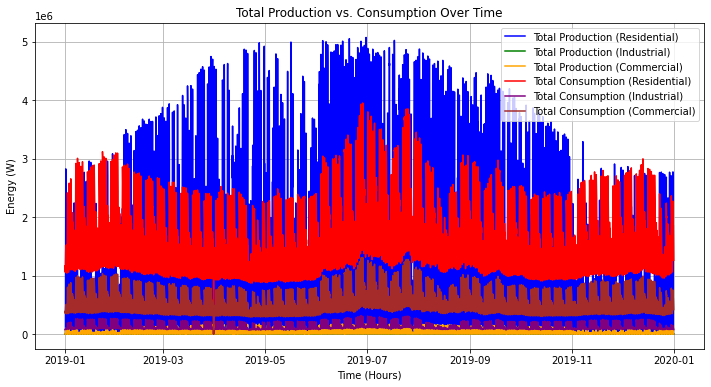

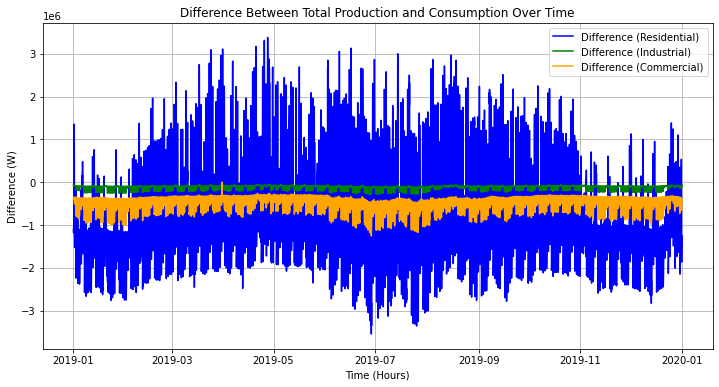

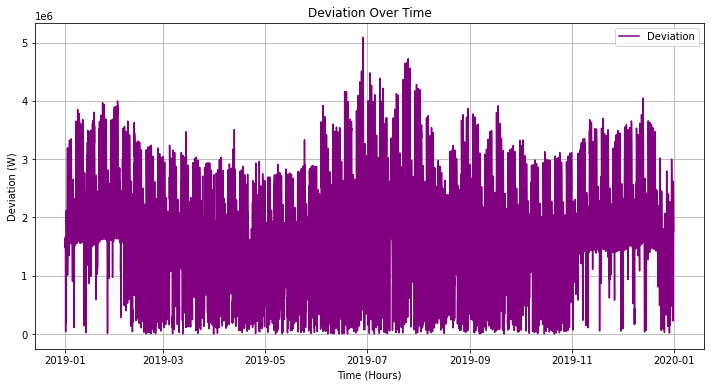

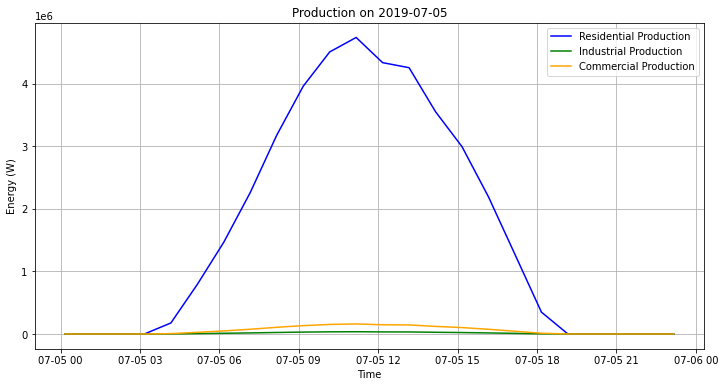

In [4]:
os.makedirs(yearly_plot_dir, exist_ok=True)
os.makedirs(weekly_plot_dir, exist_ok=True)
# Plot Total Production vs. Consumption Over Time
plt.figure(figsize=(12, 6))
plt.plot(yearlist, total_production_residential, label='Total Production (Residential)', color='blue')
plt.plot(yearlist, total_production_industrial, label='Total Production (Industrial)', color='green')
plt.plot(yearlist, total_production_commercial, label='Total Production (Commercial)', color='orange')
plt.plot(yearlist, DF_Consumption['Residential'] * Area_Res_Max, label='Total Consumption (Residential)', color='red')
plt.plot(yearlist, DF_Consumption['Industrial'] * Area_Ind_Max, label='Total Consumption (Industrial)', color='purple')
plt.plot(yearlist, DF_Consumption['Commercial'] * Area_Com_Max, label='Total Consumption (Commercial)', color='brown')
plt.xlabel('Time (Hours)')
plt.ylabel('Energy (W)')
plt.title('Total Production vs. Consumption Over Time')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(yearly_plot_dir, 'Total_Production_vs_Consumption.png'))
plt.show()

# Calculate and plot the difference between production and consumption
difference_residential = [
    total_production_residential[t] - (DF_Consumption.loc[yearlist[t], 'Residential'] * Area_Res_Max)
    for t in range(len(yearlist))
]

difference_industrial = [
    total_production_industrial[t] - (DF_Consumption.loc[yearlist[t], 'Industrial'] * Area_Ind_Max)
    for t in range(len(yearlist))
]

difference_commercial = [
    total_production_commercial[t] - (DF_Consumption.loc[yearlist[t], 'Commercial'] * Area_Com_Max)
    for t in range(len(yearlist))
]

plt.figure(figsize=(12, 6))
plt.plot(yearlist, difference_residential, label='Difference (Residential)', color='blue')
plt.plot(yearlist, difference_industrial, label='Difference (Industrial)', color='green')
plt.plot(yearlist, difference_commercial, label='Difference (Commercial)', color='orange')
plt.xlabel('Time (Hours)')
plt.ylabel('Difference (W)')
plt.title('Difference Between Total Production and Consumption Over Time')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(yearly_plot_dir, 'Difference_Production_Consumption.png'))
plt.show()

# Plot Deviation Over Time
deviation_values = [deviation[t].x for t in yearlist]
plt.figure(figsize=(12, 6))
plt.plot(yearlist, deviation_values, label='Deviation', color='purple')
plt.xlabel('Time (Hours)')
plt.ylabel('Deviation (W)')
plt.title('Deviation Over Time')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(yearly_plot_dir, 'Deviation_Over_Time.png'))
plt.show()
# Define the specific day for the detailed plot
specific_day_str = '2019-07-05'

# Filter data for the specific day
specific_day_data_residential = Residential_user_production_df.loc[Residential_user_production_df.index.strftime('%Y-%m-%d') == specific_day_str]
specific_day_data_industrial = Industrial_user_production_df.loc[Industrial_user_production_df.index.strftime('%Y-%m-%d') == specific_day_str]
specific_day_data_commercial = Commercial_user_production_df.loc[Commercial_user_production_df.index.strftime('%Y-%m-%d') == specific_day_str]

# Calculate production data for the specific day
specific_day_production_residential = specific_day_data_residential.apply(lambda col: sum(RP_values[user] * col[user] for user in DF_m2_Residential.index), axis=1)
specific_day_production_industrial = specific_day_data_industrial.apply(lambda col: sum(IP_values[user] * col[user] for user in DF_m2_Industrial.index), axis=1)
specific_day_production_commercial = specific_day_data_commercial.apply(lambda col: sum(CP_values[user] * col[user] for user in DF_m2_Commercial.index), axis=1)

# Plot production for the specific day
plt.figure(figsize=(12, 6))
plt.plot(specific_day_data_residential.index, specific_day_production_residential, label='Residential Production', color='blue')
plt.plot(specific_day_data_industrial.index, specific_day_production_industrial, label='Industrial Production', color='green')
plt.plot(specific_day_data_commercial.index, specific_day_production_commercial, label='Commercial Production', color='orange')
plt.xlabel('Time')
plt.ylabel('Energy (W)')
plt.title(f'Production on {specific_day_str}')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(yearly_plot_dir, f'Production_{specific_day_str}.png'))
plt.show()

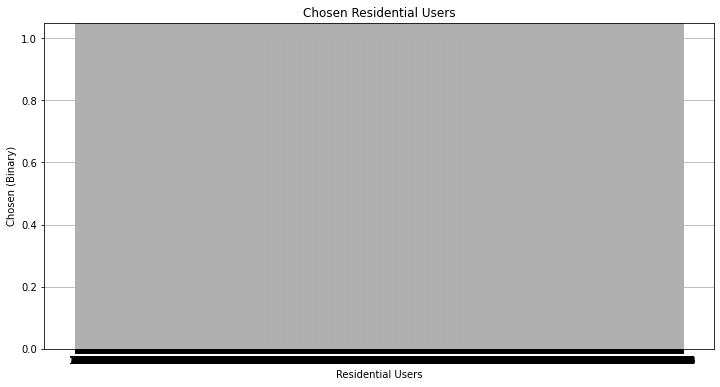

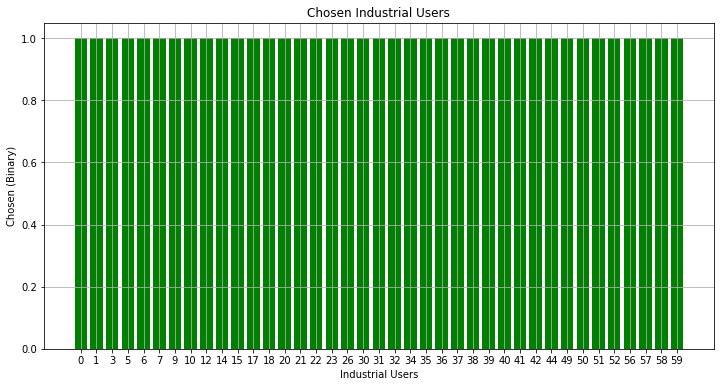

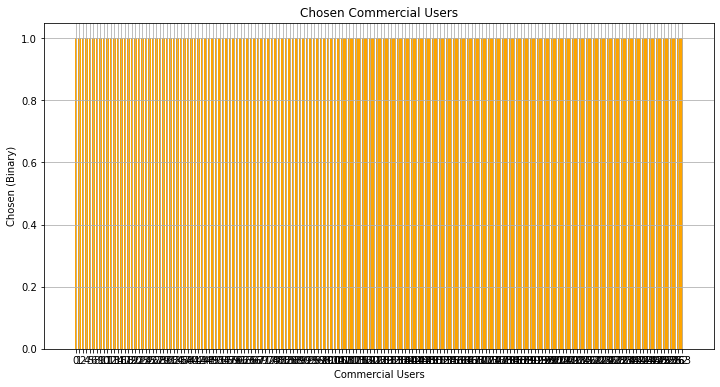

In [5]:
# Plot Chosen Residential Users
plt.figure(figsize=(12, 6))
plt.bar(chosen_residential.index, chosen_residential['Chosen'], color='blue')
plt.xlabel('Residential Users')
plt.ylabel('Chosen (Binary)')
plt.title('Chosen Residential Users')
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'Chosen_Residential_Users.png'))
plt.show()

# Plot Chosen Industrial Users
plt.figure(figsize=(12, 6))
plt.bar(chosen_industrial.index, chosen_industrial['Chosen'], color='green')
plt.xlabel('Industrial Users')
plt.ylabel('Chosen (Binary)')
plt.title('Chosen Industrial Users')
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'Chosen_Industrial_Users.png'))
plt.show()

# Plot Chosen Commercial Users
plt.figure(figsize=(12, 6))
plt.bar(chosen_commercial.index, chosen_commercial['Chosen'], color='orange')
plt.xlabel('Commercial Users')
plt.ylabel('Chosen (Binary)')
plt.title('Chosen Commercial Users')
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'Chosen_Commercial_Users.png'))
plt.show()


### Weekly Plots

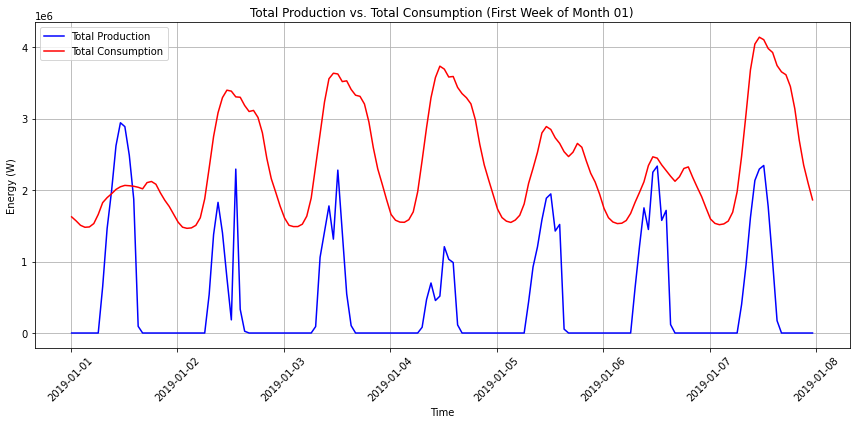

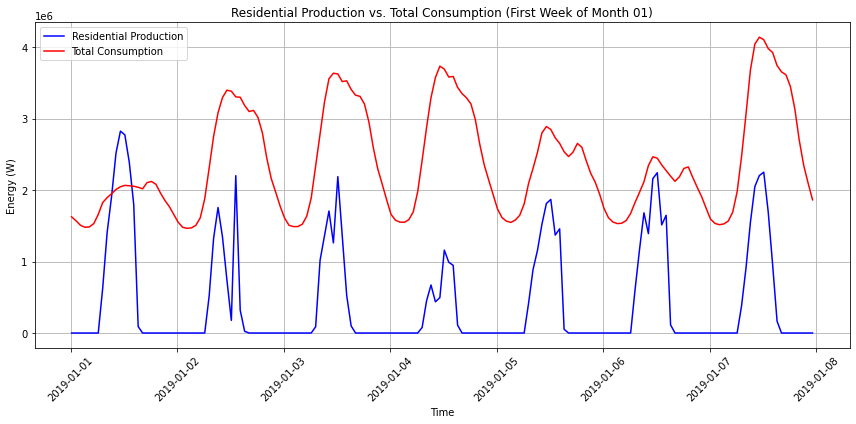

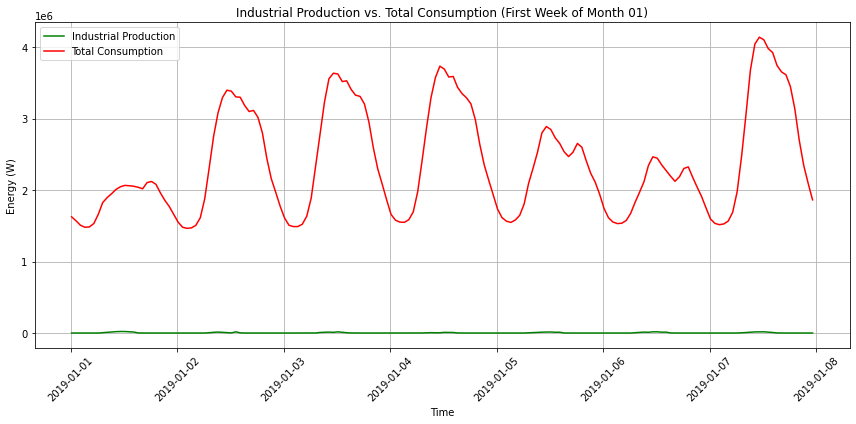

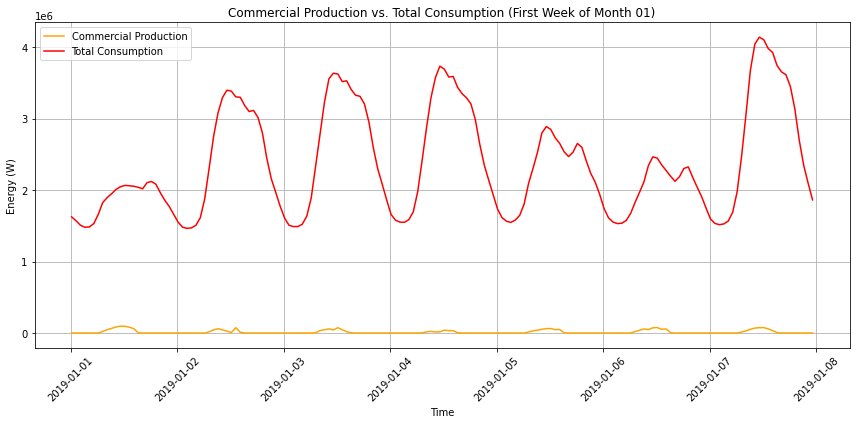

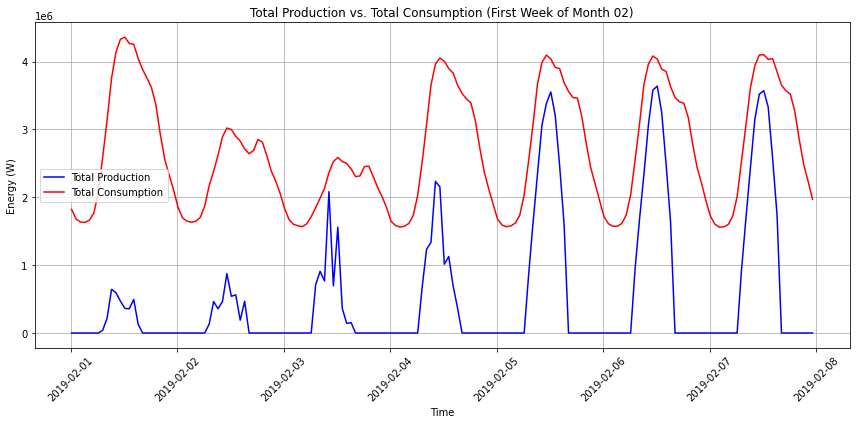

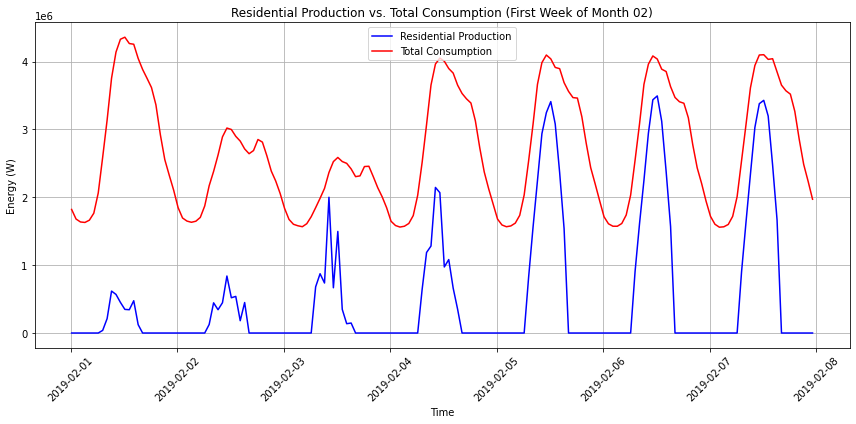

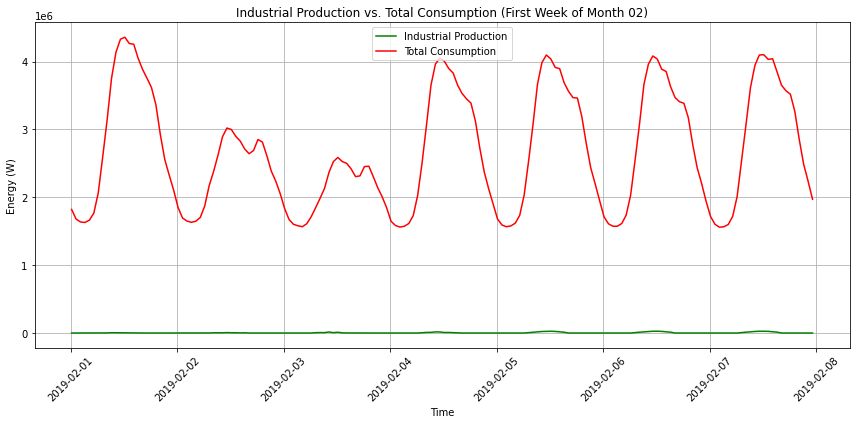

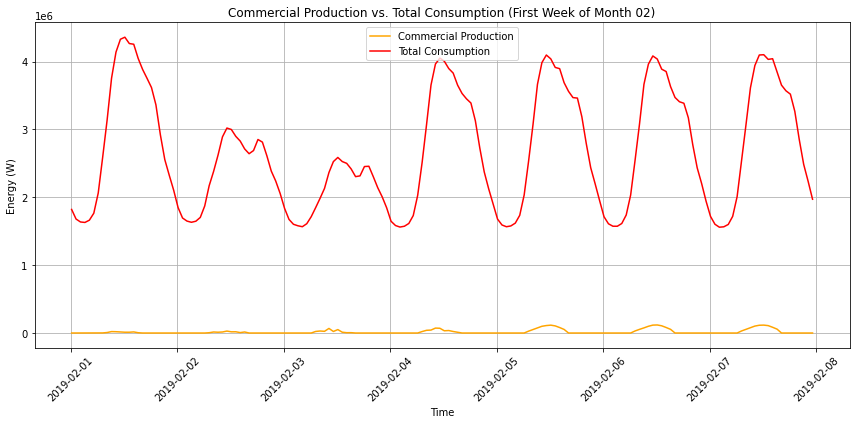

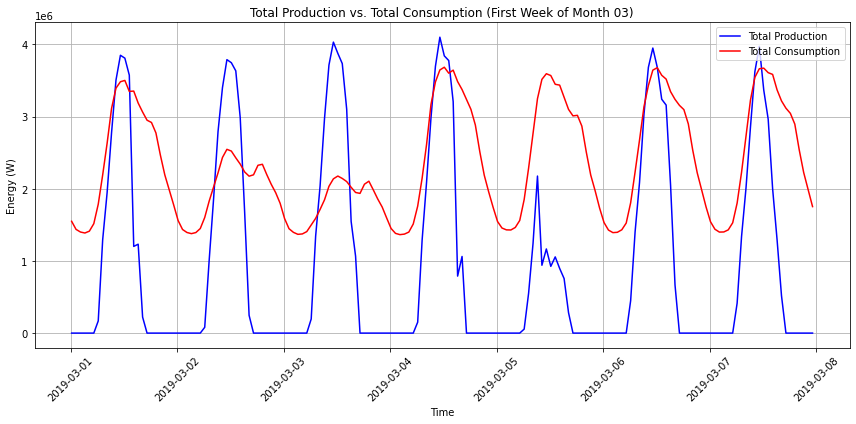

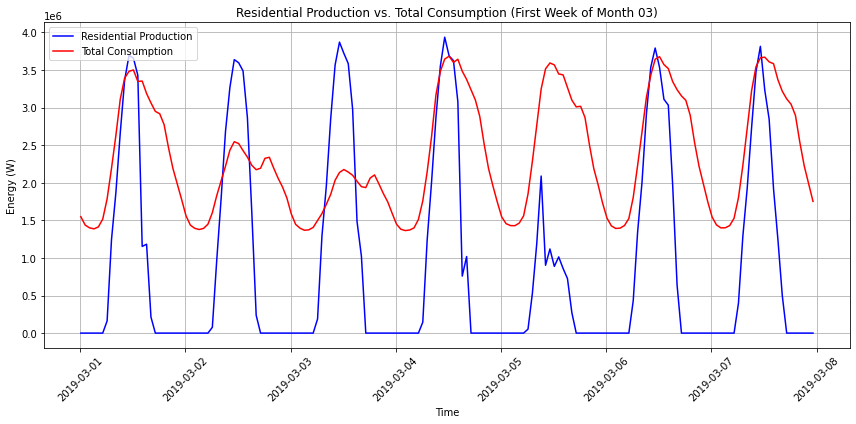

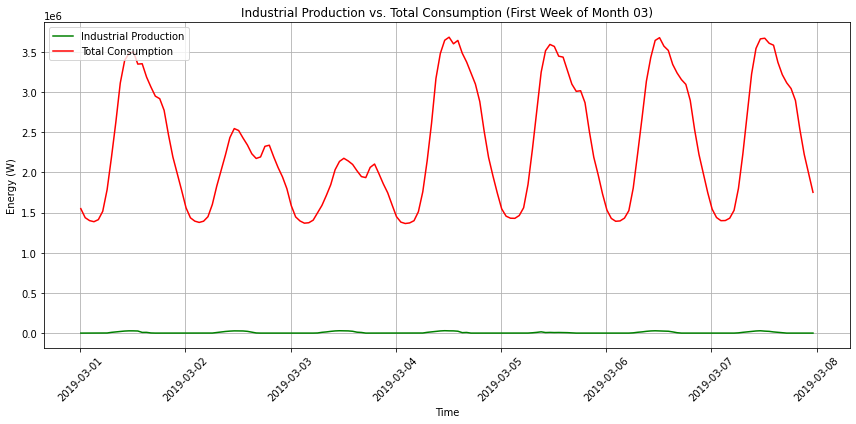

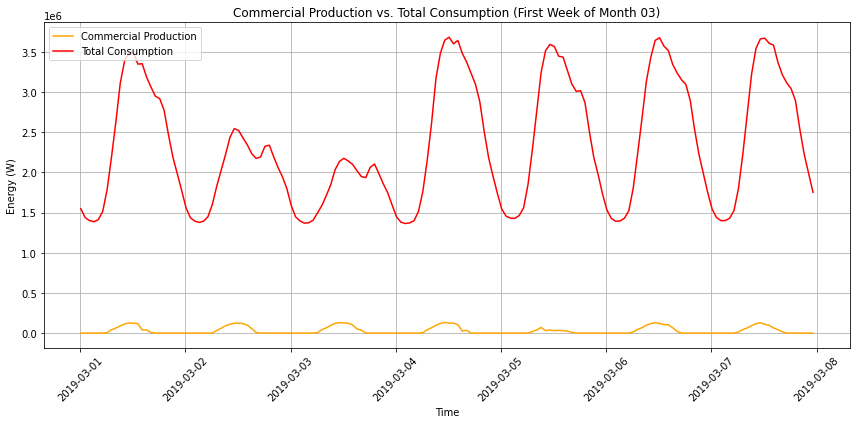

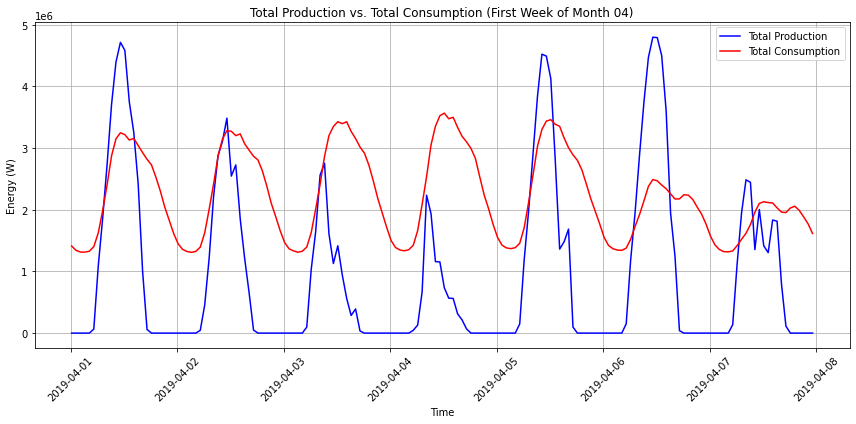

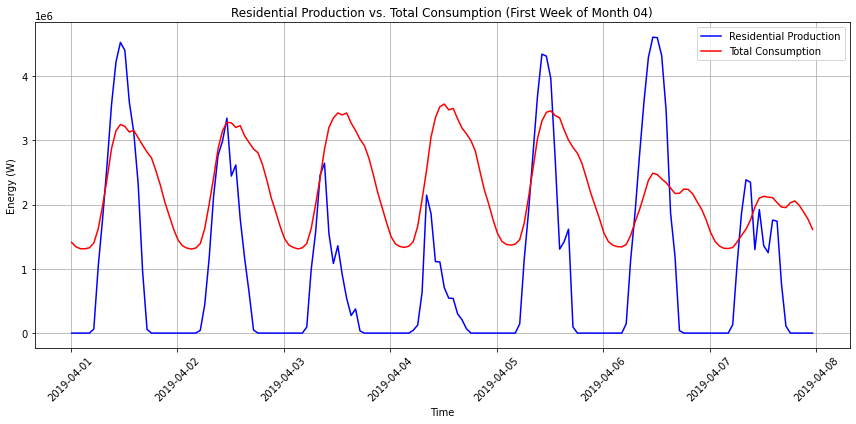

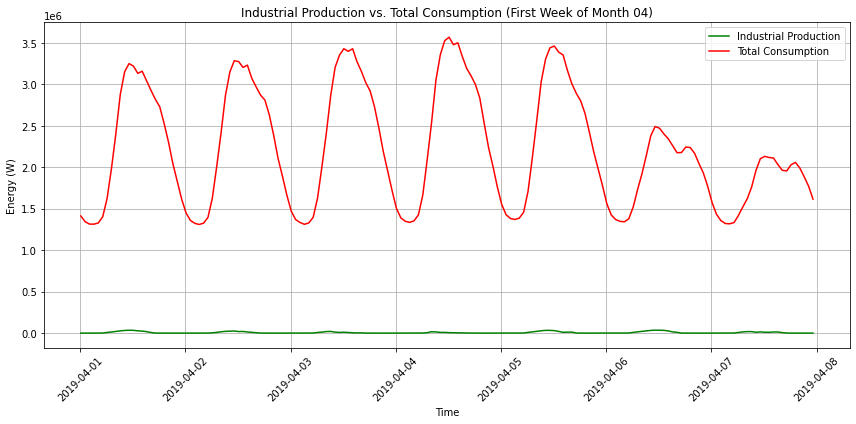

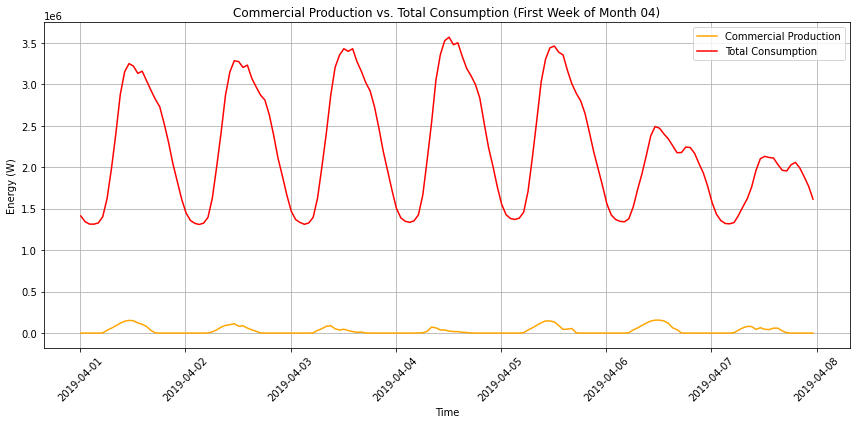

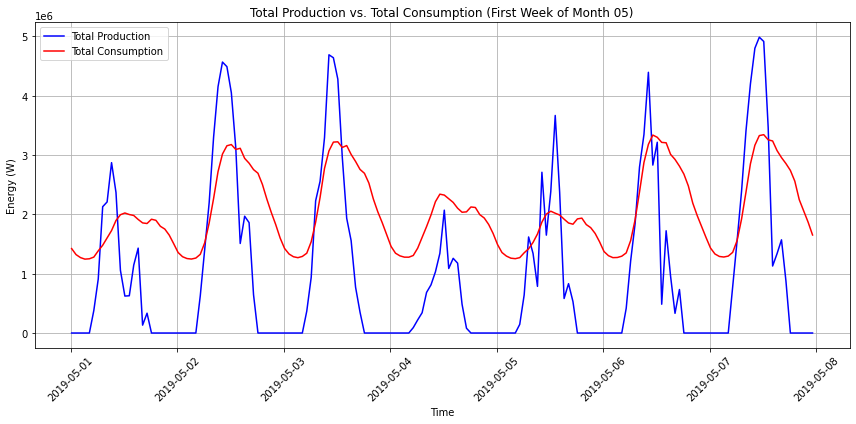

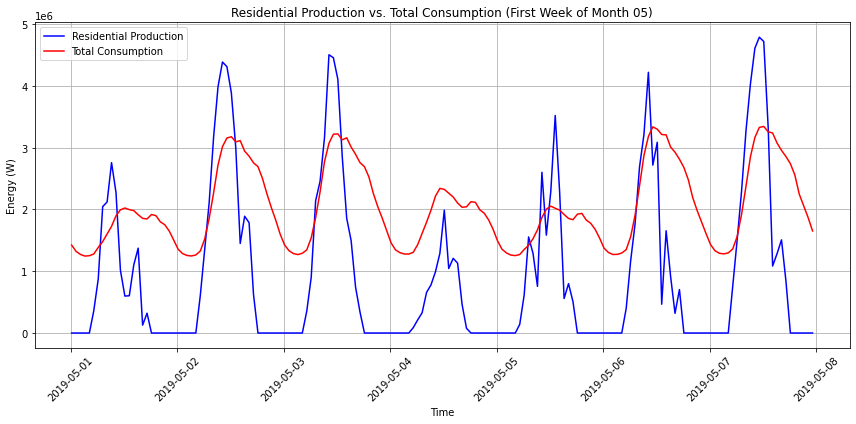

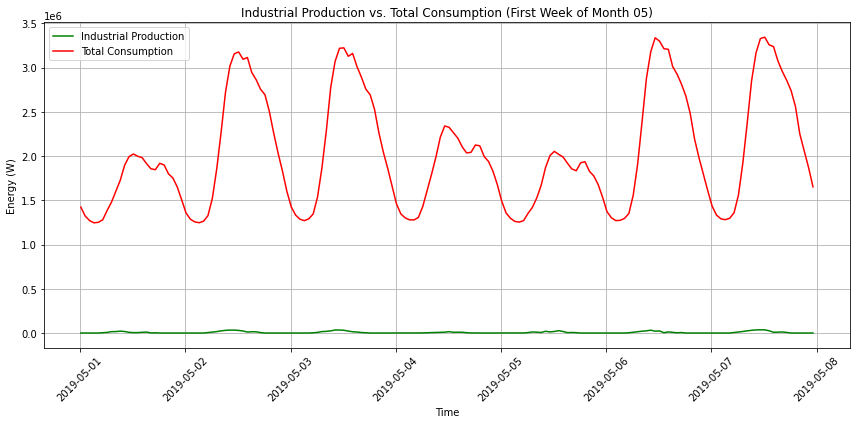

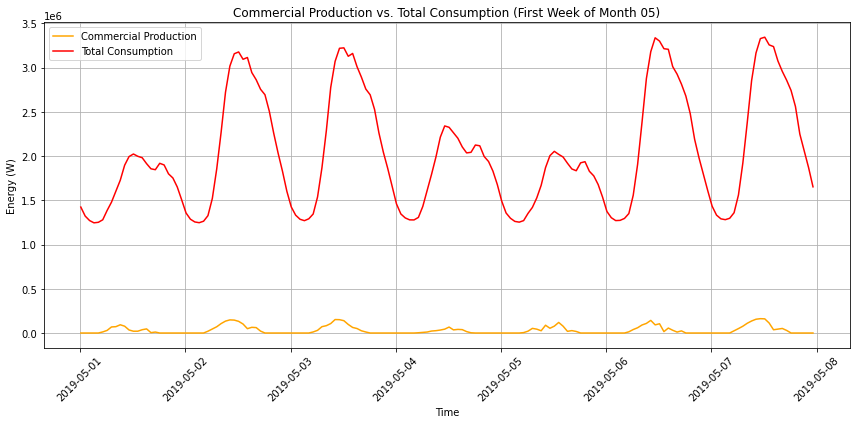

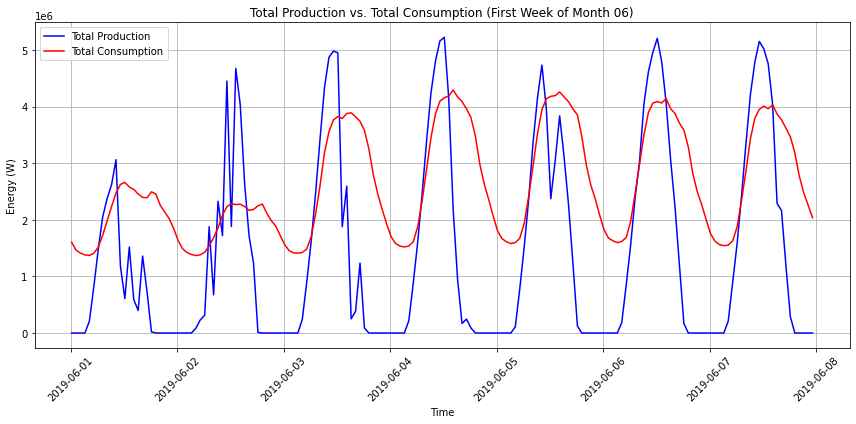

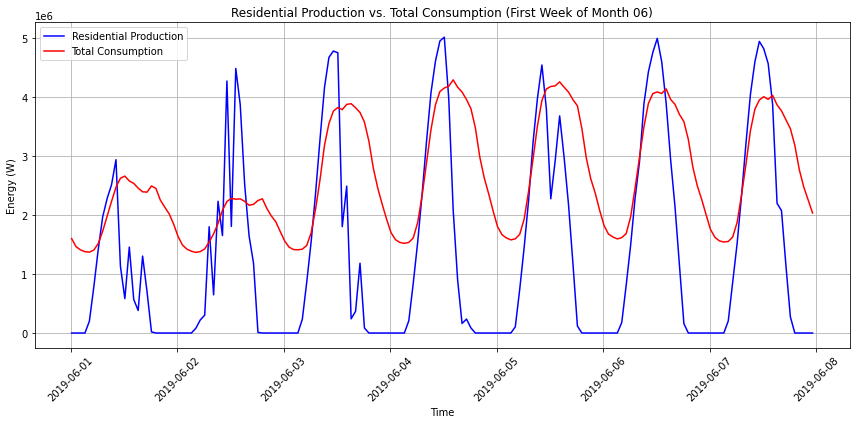

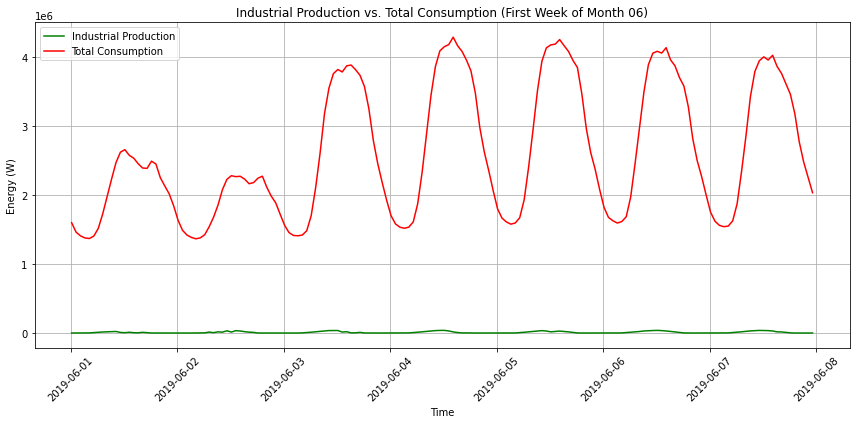

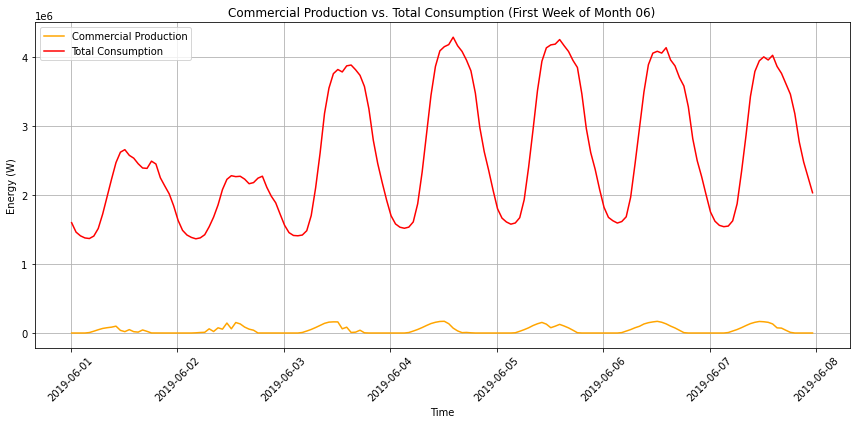

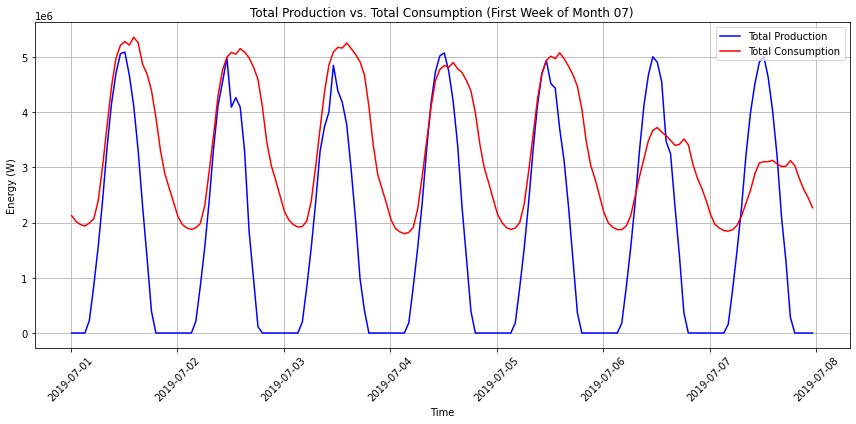

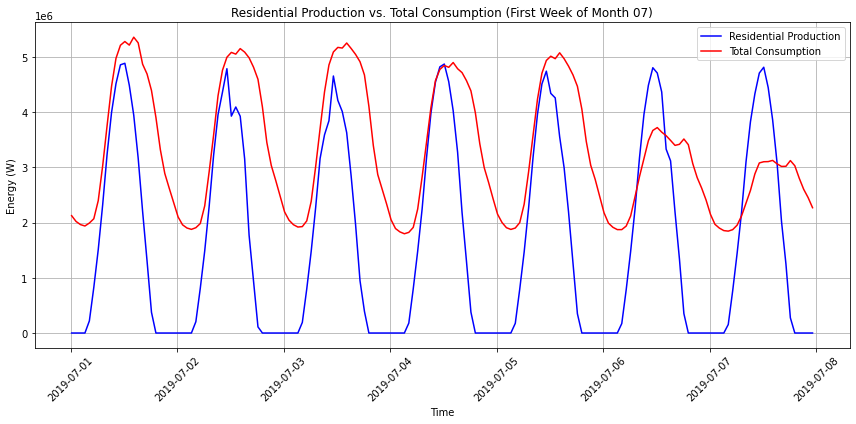

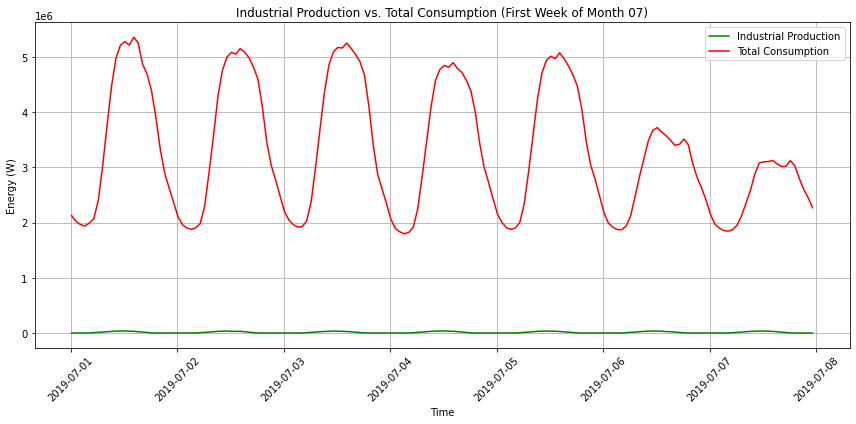

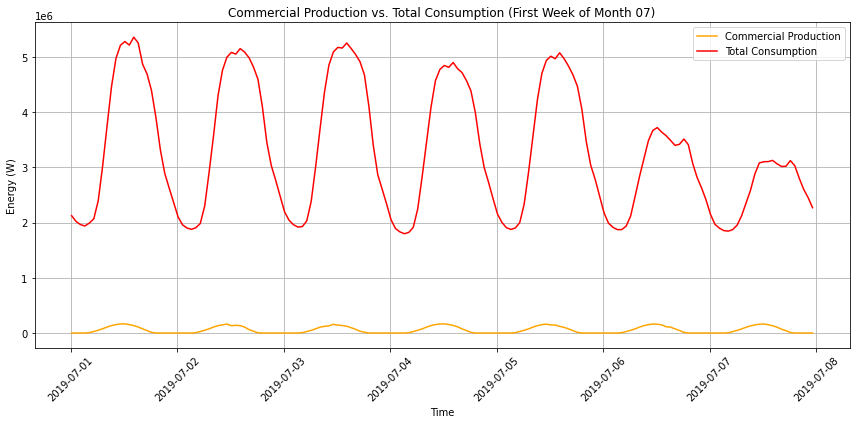

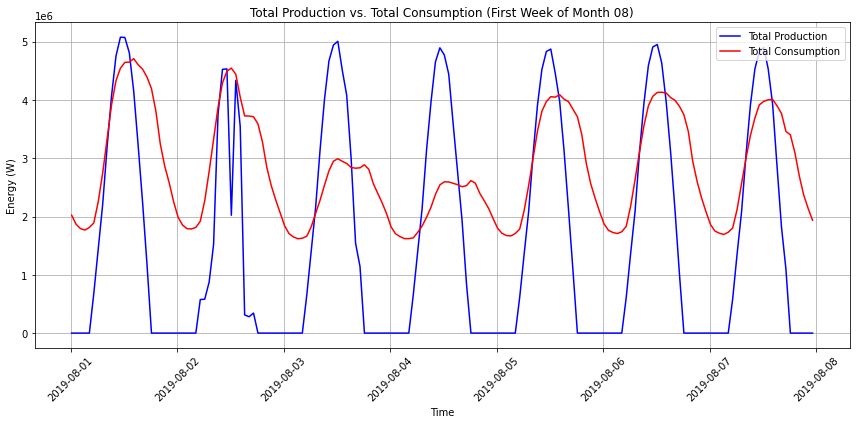

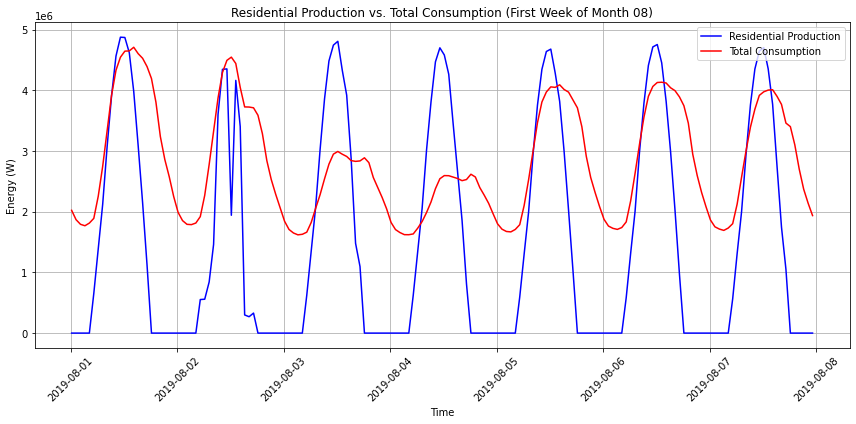

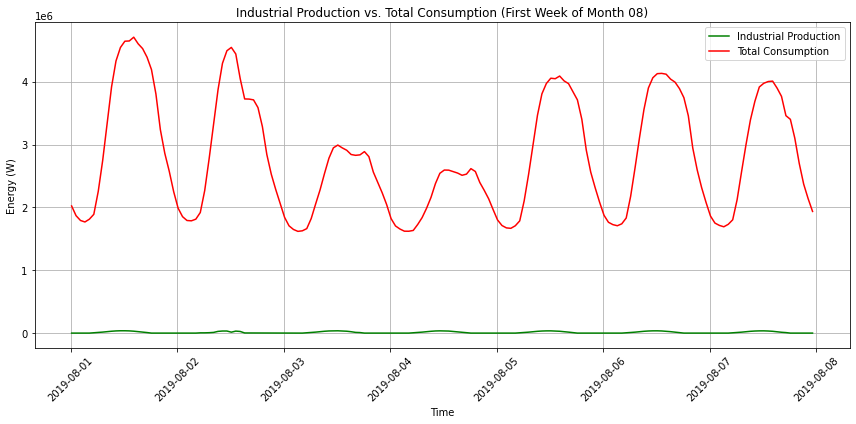

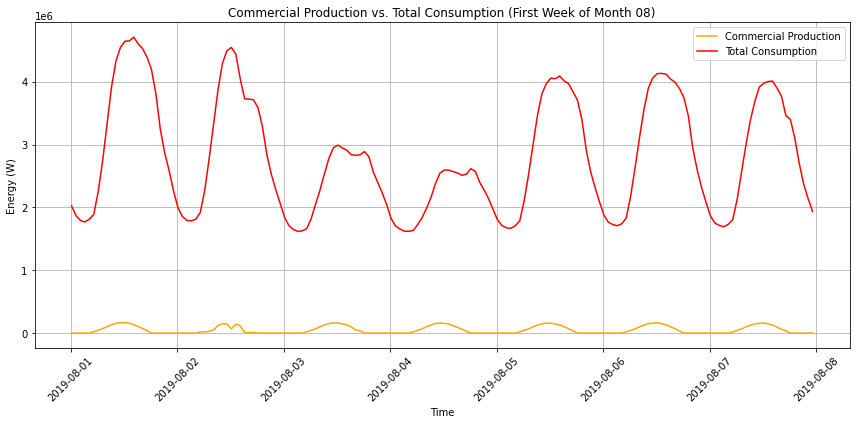

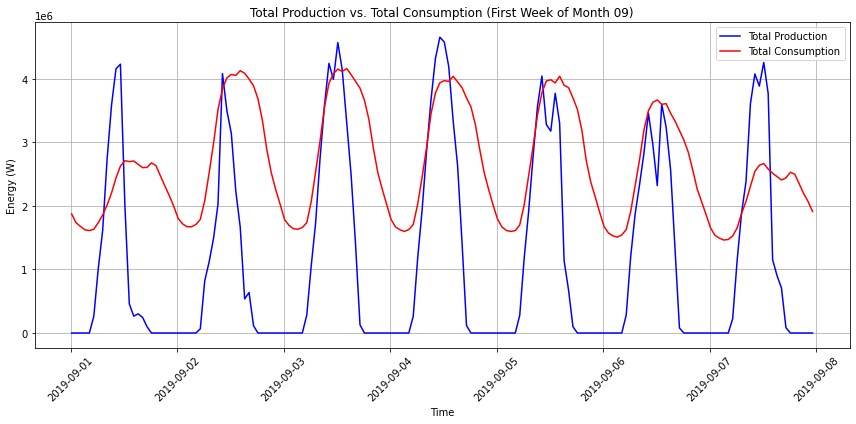

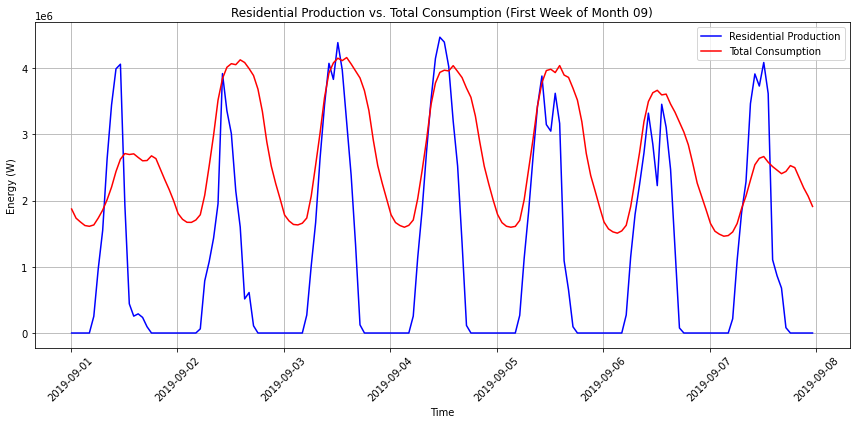

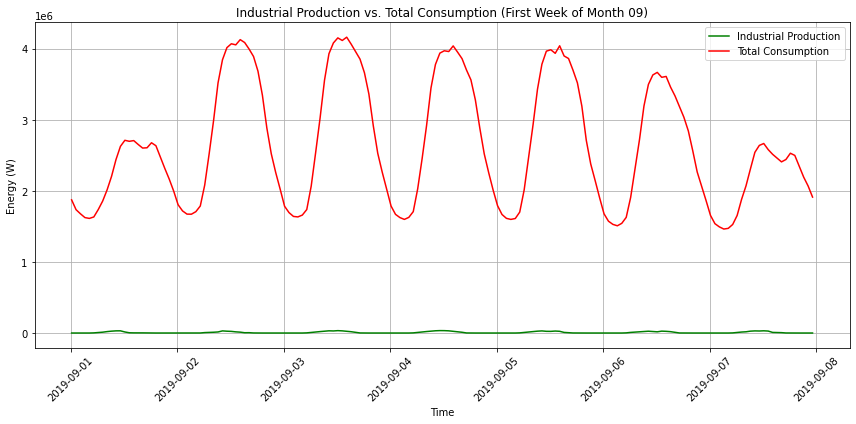

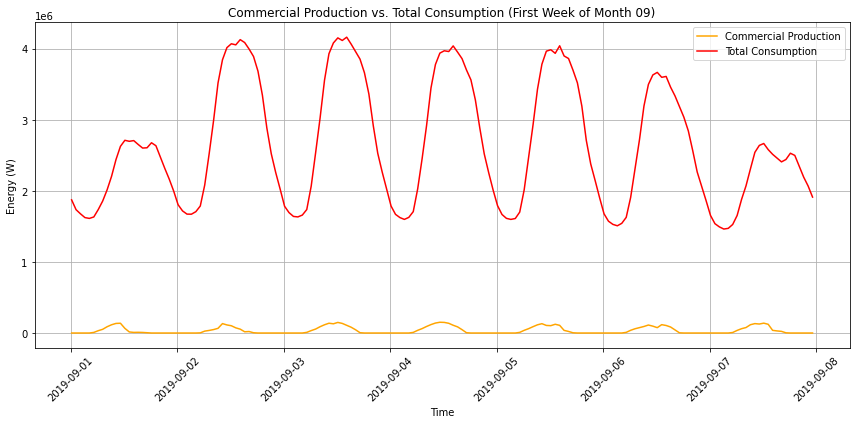

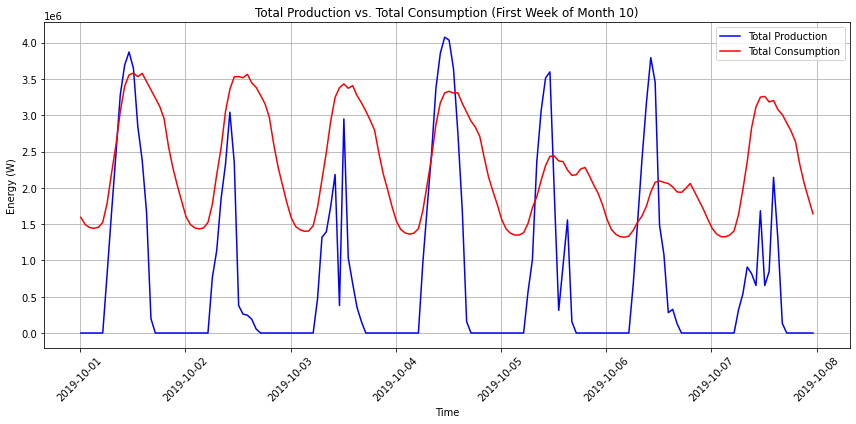

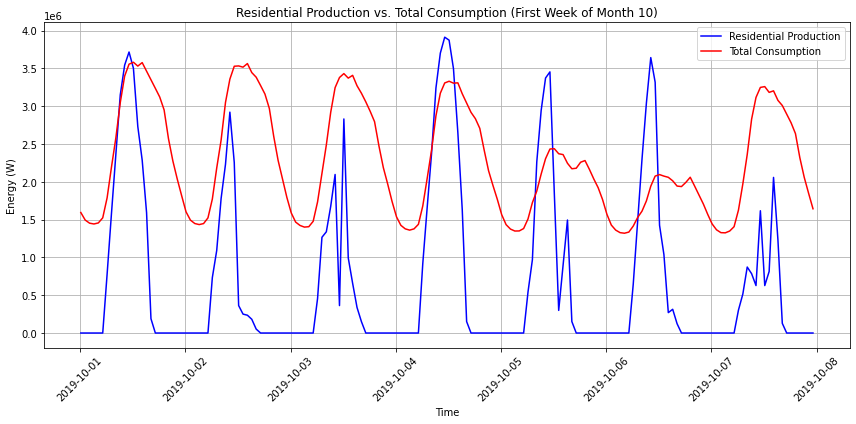

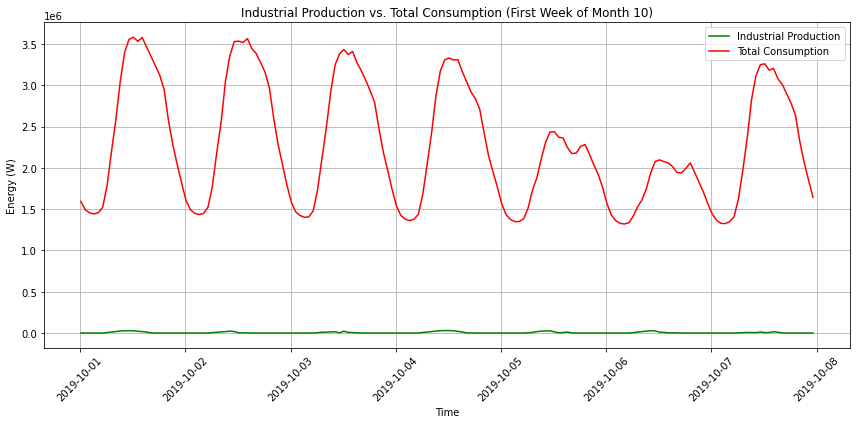

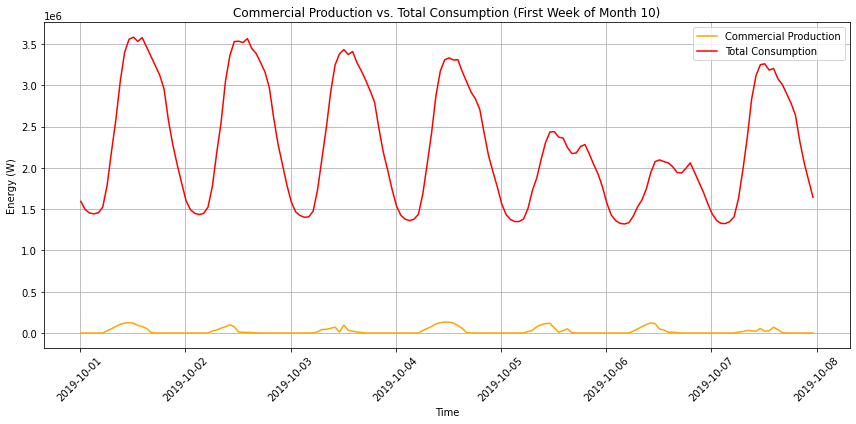

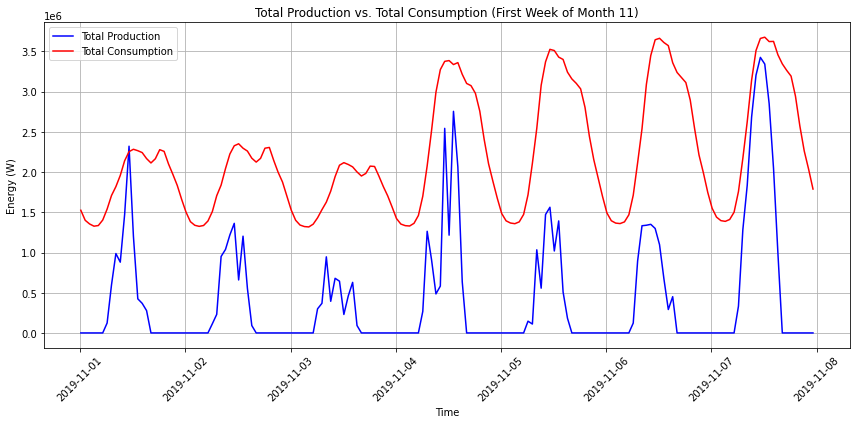

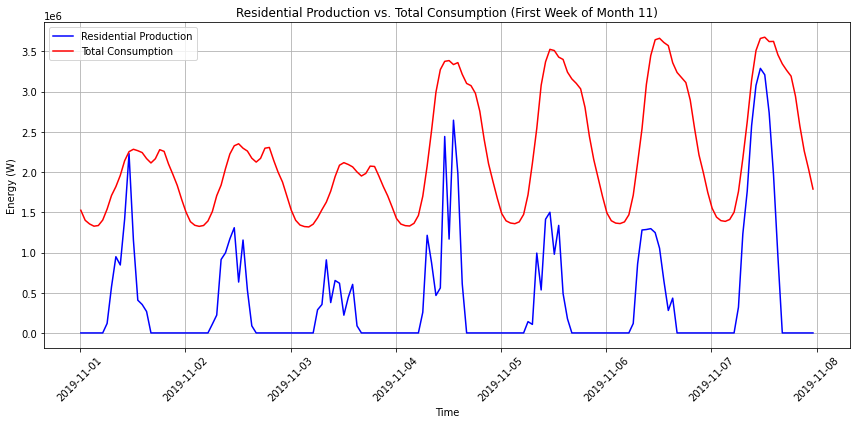

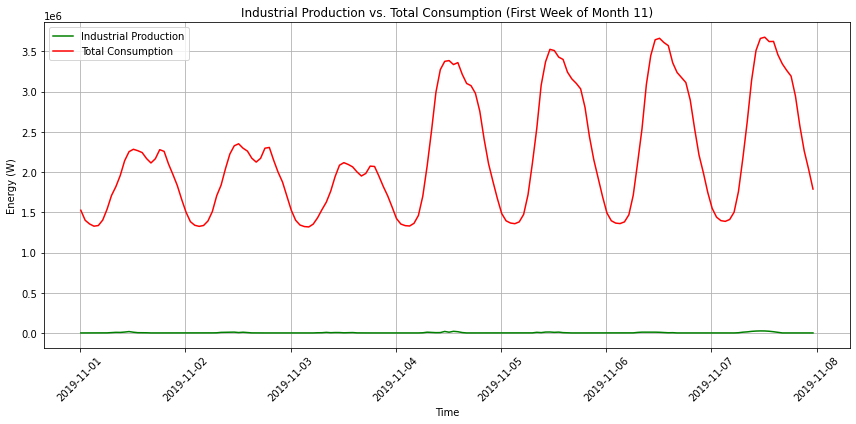

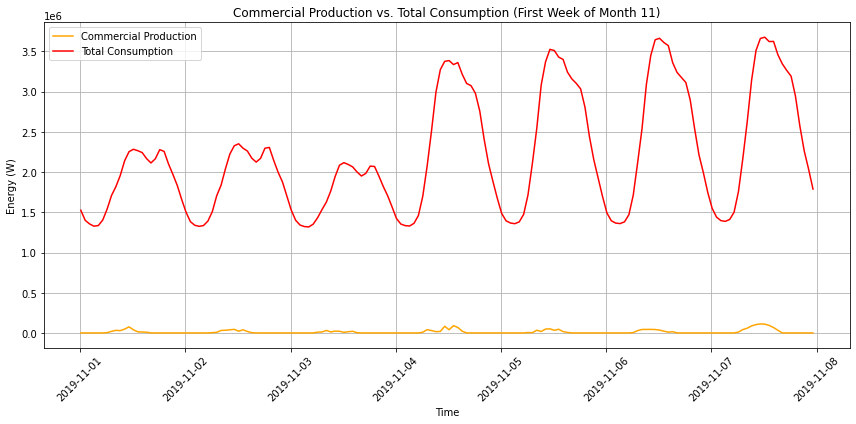

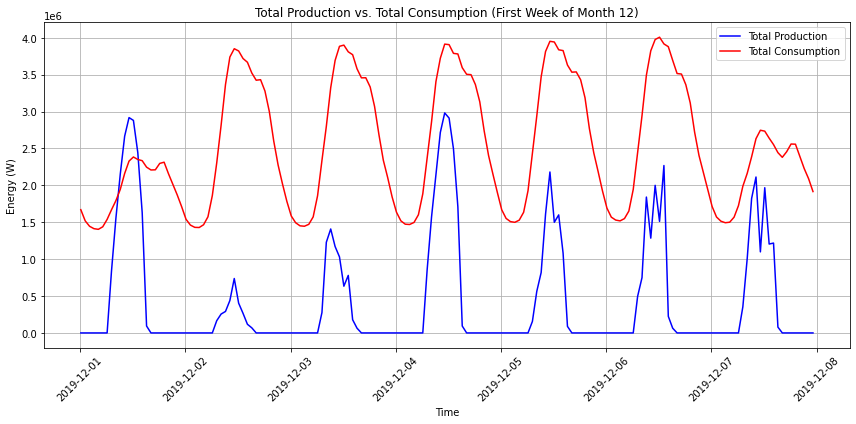

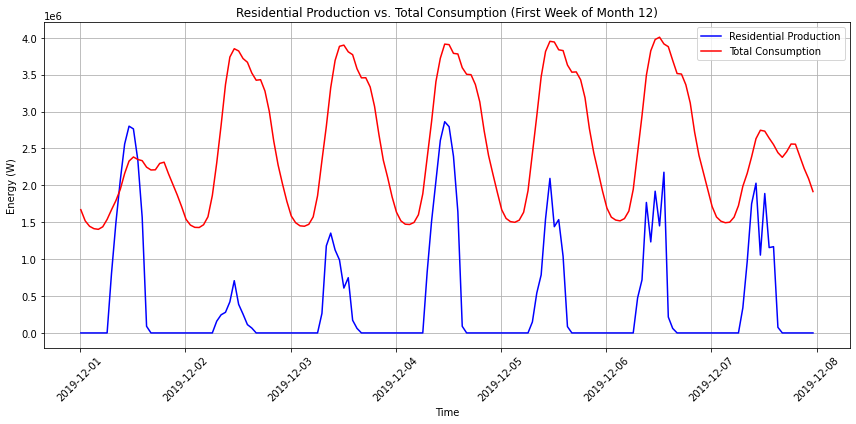

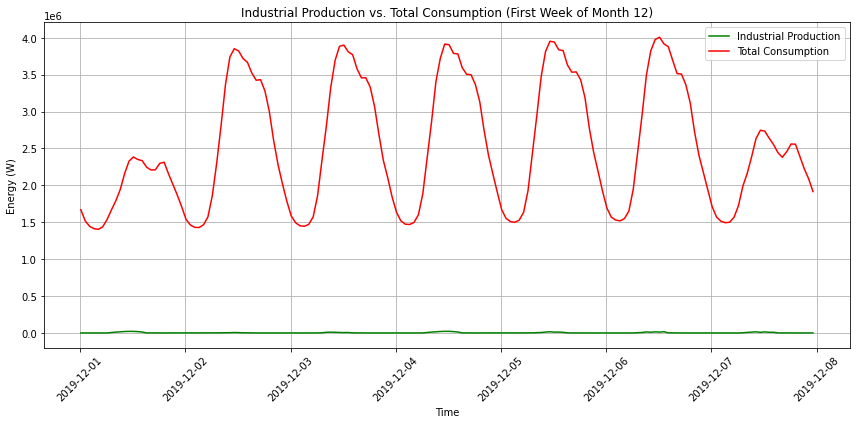

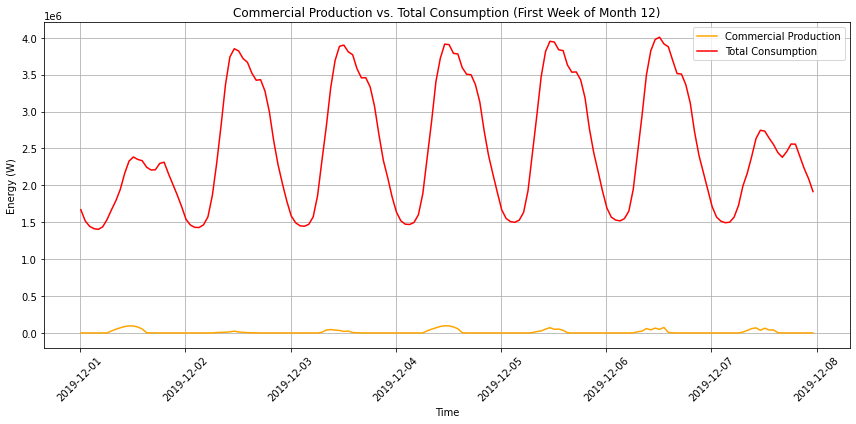

In [6]:
# Initialize a dictionary to store the results
weekly_results = {
    'Month': [],
    'F1_Percentage': [],
    'F2_Percentage': [],
    'F3_Percentage': [],
    '10am_to_4pm_Percentage': []
}


# Loop through each month to calculate percentages for each period and
# Plot the first week of each month
for month in range(1, 13):
    start_date = f'2019-{month:02d}-01'
    end_date = f'2019-{month:02d}-07'

    # Filter data for the first week of the month
    week_data = DF_Consumption.loc[start_date:end_date]
    
    # Calculate production for each user type
    week_production_residential = [sum(RP_values[user] * Residential_user_production_df.loc[date, user] for user in DF_m2_Residential.index) for date in week_data.index]
    week_production_industrial = [sum(IP_values[user] * Industrial_user_production_df.loc[date, user] for user in DF_m2_Industrial.index) for date in week_data.index]
    week_production_commercial = [sum(CP_values[user] * Commercial_user_production_df.loc[date, user] for user in DF_m2_Commercial.index) for date in week_data.index]
    week_production_total = [week_production_residential[i] + week_production_industrial[i] + week_production_commercial[i] for i in range(len(week_data.index))]
    
    # Total consumption for the week
    week_consumption_total = week_data['Residential'] * Area_Res_Max + week_data['Industrial'] * Area_Ind_Max + week_data['Commercial'] * Area_Com_Max

    # Convert index to datetime if not already
    week_data.index = pd.to_datetime(week_data.index)

    # Define F1, F2, F3 periods and 10am to 4pm
    F1_mask = (week_data.index.weekday < 5) & (week_data.index.hour >= 8) & (week_data.index.hour < 19)
    F2_mask = ((week_data.index.weekday < 5) & ((week_data.index.hour >= 7) & (week_data.index.hour < 8) | (week_data.index.hour >= 19) & (week_data.index.hour < 23))) | \
              ((week_data.index.weekday == 5) & (week_data.index.hour >= 7) & (week_data.index.hour < 23))
    F3_mask = ((week_data.index.weekday < 6) & (week_data.index.hour >= 23)) | (week_data.index.hour < 7) | (week_data.index.weekday == 6)
    time_10am_4pm_mask = (week_data.index.hour >= 10) & (week_data.index.hour < 16)

    # Calculate total production and consumption for each period
    total_production_F1 = sum([week_production_total[i] for i in range(len(week_data)) if F1_mask[i]])
    total_consumption_F1 = sum([week_consumption_total[i] for i in range(len(week_data)) if F1_mask[i]])
    F1_percentage = (total_production_F1 / total_consumption_F1) * 100 if total_consumption_F1 > 0 else 0

    total_production_F2 = sum([week_production_total[i] for i in range(len(week_data)) if F2_mask[i]])
    total_consumption_F2 = sum([week_consumption_total[i] for i in range(len(week_data)) if F2_mask[i]])
    F2_percentage = (total_production_F2 / total_consumption_F2) * 100 if total_consumption_F2 > 0 else 0

    total_production_F3 = sum([week_production_total[i] for i in range(len(week_data)) if F3_mask[i]])
    total_consumption_F3 = sum([week_consumption_total[i] for i in range(len(week_data)) if F3_mask[i]])
    F3_percentage = (total_production_F3 / total_consumption_F3) * 100 if total_consumption_F3 > 0 else 0

    total_production_10am_4pm = sum([week_production_total[i] for i in range(len(week_data)) if time_10am_4pm_mask[i]])
    total_consumption_10am_4pm = sum([week_consumption_total[i] for i in range(len(week_data)) if time_10am_4pm_mask[i]])
    percentage_10am_4pm = (total_production_10am_4pm / total_consumption_10am_4pm) * 100 if total_consumption_10am_4pm > 0 else 0

    # Append results for each month
    weekly_results['Month'].append(month)
    weekly_results['F1_Percentage'].append(F1_percentage)
    weekly_results['F2_Percentage'].append(F2_percentage)
    weekly_results['F3_Percentage'].append(F3_percentage)
    weekly_results['10am_to_4pm_Percentage'].append(percentage_10am_4pm)

    '''week_data = DF_Consumption.loc[start_date:end_date]'''
    week_production_residential = [sum(RP_values[user] * Residential_user_production_df.loc[date, user] for user in DF_m2_Residential.index) for date in week_data.index]
    week_production_industrial = [sum(IP_values[user] * Industrial_user_production_df.loc[date, user] for user in DF_m2_Industrial.index) for date in week_data.index]
    week_production_commercial = [sum(CP_values[user] * Commercial_user_production_df.loc[date, user] for user in DF_m2_Commercial.index) for date in week_data.index]
    week_production_total = [week_production_residential[i] + week_production_industrial[i] + week_production_commercial[i] for i in range(len(week_data.index))]

    plt.figure(figsize=(12, 6))
    plt.plot(week_data.index, week_production_total, label='Total Production', color='blue')
    plt.plot(week_data.index, week_data['Residential'] * Area_Res_Max + week_data['Industrial'] * Area_Ind_Max + week_data['Commercial'] * Area_Com_Max, label='Total Consumption', color='red')
    plt.xlabel('Time')
    plt.ylabel('Energy (W)')
    plt.title(f'Total Production vs. Total Consumption (First Week of Month {month:02d})')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(weekly_plot_dir, f'Total_Production_vs_Total_Consumption_Week_{month:02d}.png'))
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(week_data.index, week_production_residential, label='Residential Production', color='blue')
    plt.plot(week_data.index, week_data['Residential'] * Area_Res_Max + week_data['Industrial'] * Area_Ind_Max + week_data['Commercial'] * Area_Com_Max, label='Total Consumption', color='red')
    plt.xlabel('Time')
    plt.ylabel('Energy (W)')
    plt.title(f'Residential Production vs. Total Consumption (First Week of Month {month:02d})')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(weekly_plot_dir, f'Residential_Production_vs_Total_Consumption_Week_{month:02d}.png'))
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(week_data.index, week_production_industrial, label='Industrial Production', color='green')
    plt.plot(week_data.index, week_data['Residential'] * Area_Res_Max + week_data['Industrial'] * Area_Ind_Max + week_data['Commercial'] * Area_Com_Max, label='Total Consumption', color='red')
    plt.xlabel('Time')
    plt.ylabel('Energy (W)')
    plt.title(f'Industrial Production vs. Total Consumption (First Week of Month {month:02d})')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(weekly_plot_dir, f'Industrial_Production_vs_Total_Consumption_Week_{month:02d}.png'))
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(week_data.index, week_production_commercial, label='Commercial Production', color='orange')
    plt.plot(week_data.index, week_data['Residential'] * Area_Res_Max + week_data['Industrial'] * Area_Ind_Max + week_data['Commercial'] * Area_Com_Max, label='Total Consumption', color='red')
    plt.xlabel('Time')
    plt.ylabel('Energy (W)')
    plt.title(f'Commercial Production vs. Total Consumption (First Week of Month {month:02d})')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(weekly_plot_dir, f'Commercial_Production_vs_Total_Consumption_Week_{month:02d}.png'))
    plt.show()

# Convert results to DataFrame
weekly_results_df = pd.DataFrame(weekly_results)

# Save the results to Excel and CSV
output_file_path_excel = os.path.join(weekly_plot_dir, 'Weekly_Percentage_Results.xlsx')
output_file_path_csv = os.path.join(weekly_plot_dir, 'Weekly_Percentage_Results.csv')

weekly_results_df.to_excel(output_file_path_excel, index=False)
weekly_results_df.to_csv(output_file_path_csv, index=False)

print(f'Results saved to {output_file_path_excel} and {output_file_path_csv}')


In [7]:
'''# Initialize a dictionary to store the results
weekly_results = {
    'Month': [],
    'F1_Percentage': [],
    'F2_Percentage': [],
    'F3_Percentage': [],
    '10am_to_4pm_Percentage': []
}

# Loop through each month to calculate percentages for each period
for month in range(1, 13):
    start_date = f'2019-{month:02d}-01'
    end_date = f'2019-{month:02d}-07'
    
    # Filter data for the first week of the month
    week_data = DF_Consumption.loc[start_date:end_date]
    
    # Calculate production for each user type
    week_production_residential = [sum(RP_values[user] * Residential_user_production_df.loc[date, user] for user in DF_m2_Residential.index) for date in week_data.index]
    week_production_industrial = [sum(IP_values[user] * Industrial_user_production_df.loc[date, user] for user in DF_m2_Industrial.index) for date in week_data.index]
    week_production_commercial = [sum(CP_values[user] * Commercial_user_production_df.loc[date, user] for user in DF_m2_Commercial.index) for date in week_data.index]
    week_production_total = [week_production_residential[i] + week_production_industrial[i] + week_production_commercial[i] for i in range(len(week_data.index))]
    
    # Total consumption for the week
    week_consumption_total = week_data['Residential'] * Area_Res_Max + week_data['Industrial'] * Area_Ind_Max + week_data['Commercial'] * Area_Com_Max

    # Convert index to datetime if not already
    week_data.index = pd.to_datetime(week_data.index)

    # Define F1, F2, F3 periods and 10am to 4pm
    F1_mask = (week_data.index.weekday < 5) & (week_data.index.hour >= 8) & (week_data.index.hour < 19)
    F2_mask = ((week_data.index.weekday < 5) & ((week_data.index.hour >= 7) & (week_data.index.hour < 8) | (week_data.index.hour >= 19) & (week_data.index.hour < 23))) | \
              ((week_data.index.weekday == 5) & (week_data.index.hour >= 7) & (week_data.index.hour < 23))
    F3_mask = ((week_data.index.weekday < 6) & (week_data.index.hour >= 23)) | (week_data.index.hour < 7) | (week_data.index.weekday == 6)
    time_10am_4pm_mask = (week_data.index.hour >= 10) & (week_data.index.hour < 16)

    # Calculate total production and consumption for each period
    total_production_F1 = sum([week_production_total[i] for i in range(len(week_data)) if F1_mask[i]])
    total_consumption_F1 = sum([week_consumption_total[i] for i in range(len(week_data)) if F1_mask[i]])
    F1_percentage = (total_production_F1 / total_consumption_F1) * 100 if total_consumption_F1 > 0 else 0

    total_production_F2 = sum([week_production_total[i] for i in range(len(week_data)) if F2_mask[i]])
    total_consumption_F2 = sum([week_consumption_total[i] for i in range(len(week_data)) if F2_mask[i]])
    F2_percentage = (total_production_F2 / total_consumption_F2) * 100 if total_consumption_F2 > 0 else 0

    total_production_F3 = sum([week_production_total[i] for i in range(len(week_data)) if F3_mask[i]])
    total_consumption_F3 = sum([week_consumption_total[i] for i in range(len(week_data)) if F3_mask[i]])
    F3_percentage = (total_production_F3 / total_consumption_F3) * 100 if total_consumption_F3 > 0 else 0

    total_production_10am_4pm = sum([week_production_total[i] for i in range(len(week_data)) if time_10am_4pm_mask[i]])
    total_consumption_10am_4pm = sum([week_consumption_total[i] for i in range(len(week_data)) if time_10am_4pm_mask[i]])
    percentage_10am_4pm = (total_production_10am_4pm / total_consumption_10am_4pm) * 100 if total_consumption_10am_4pm > 0 else 0

    # Append results for each month
    weekly_results['Month'].append(month)
    weekly_results['F1_Percentage'].append(F1_percentage)
    weekly_results['F2_Percentage'].append(F2_percentage)
    weekly_results['F3_Percentage'].append(F3_percentage)
    weekly_results['10am_to_4pm_Percentage'].append(percentage_10am_4pm)

# Convert results to DataFrame
weekly_results_df = pd.DataFrame(weekly_results)

# Save the results to Excel and CSV
output_file_path_excel = os.path.join(weekly_plot_dir, 'Weekly_Percentage_Results.xlsx')
output_file_path_csv = os.path.join(weekly_plot_dir, 'Weekly_Percentage_Results.csv')

weekly_results_df.to_excel(output_file_path_excel, index=False)
weekly_results_df.to_csv(output_file_path_csv, index=False)

print(f'Results saved to {output_file_path_excel} and {output_file_path_csv}')
'''

Results saved to C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results\2024-09-02_09-41-29\Plot\Weekly_Plot\Weekly_Percentage_Results.xlsx and C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results\2024-09-02_09-41-29\Plot\Weekly_Plot\Weekly_Percentage_Results.csv


In [8]:
# Calculate averages for chosen users in each category
def calculate_averages(df, category_name):
    avg_area = df['Area'].mean() if 'Area' in df.columns else None
    avg_s_coeff = df['S_coeff'].mean() if 'S_coeff' in df.columns else None
    avg_w_coeff = df['W_coeff'].mean() if 'W_coeff' in df.columns else None
    avg_e_coeff = df['E_coeff'].mean() if 'E_coeff' in df.columns else None

    return {
        'Category': category_name,
        'Average Area': avg_area,
        'Average S_coeff': avg_s_coeff,
        'Average W_coeff': avg_w_coeff,
        'Average E_coeff': avg_e_coeff
    }

# Calculate averages for each category
averages_residential = calculate_averages(chosen_residential, 'Residential')
averages_industrial = calculate_averages(chosen_industrial, 'Industrial')
averages_commercial = calculate_averages(chosen_commercial, 'Commercial')

# Combine results into a single DataFrame
averages_df = pd.DataFrame([averages_residential, averages_industrial, averages_commercial])

# Print the averages to check
print(averages_df)

# Save the results to CSV and Excel
averages_file_path_csv = os.path.join(results_dir, 'Averages_Chosen_Users.csv')
averages_file_path_excel = os.path.join(results_dir, 'Averages_Chosen_Users.xlsx')

averages_df.to_csv(averages_file_path_csv, index=False)
averages_df.to_excel(averages_file_path_excel, index=False)

print(f'Averages saved to {averages_file_path_csv} and {averages_file_path_excel}')


      Category  Average Area  Average S_coeff  Average W_coeff  \
0  Residential     21.757208         0.271114         0.427726   
1   Industrial    134.248274         0.264872         0.433846   
2   Commercial    180.860393         0.272529         0.438736   

   Average E_coeff  
0         0.301145  
1         0.301282  
2         0.288736  
Averages saved to C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results\2024-09-02_09-41-29\Averages_Chosen_Users.csv and C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results\2024-09-02_09-41-29\Averages_Chosen_Users.xlsx
